<a href="https://colab.research.google.com/github/jeshmin-shrestha/-Realistic-Image-Reconstruction-GAN-VAE/blob/main/TASK_1_VAE_and_GAN_Hybrid_Jeshmin_Shrestha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1: Hybrid VAE–GAN for Realistic Image Reconstruction

In [ ]:
from google.colab import files
import os

print("kaggle.json file:")
uploaded = files.upload()

# Set up Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle --quiet

print("Kaggle API setup complete!")

kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API setup complete!


IMPORTS AND SETUP

Importing all the encessary ibraries and setting up the computing device

PyTorch for the deep learning

torchvision for image processing

Using GPU for the optimal performance

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import os
from tqdm import tqdm
from PIL import Image
import glob
import zipfile

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


CONFIGURATION CLASS
This class centrailizes configuration for all the hyperparaters and model settings
the Key pararmters include:
1. batch size
2. Latent dimension
3. Learning rates
4. loss weights

In [ ]:
# Configuration for CelebA
class Config:
    batch_size = 128
    latent_dim = 128
    image_size = 64
    channels = 3
    lr = 0.0002
    beta1 = 0.5
    epochs = 40  # Reduced for faster training
    kl_weight = 0.01
    recon_weight = 10.0
    gan_weight = 0.1

CUSTOM DATASET LOADER


This class handles the dataset loadung and preprocing of the CelebA dataset

In [ ]:
# Custom CelebA Dataset loader
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Look for images in various possible locations
        possible_paths = [
            os.path.join(root_dir, 'img_align_celeba', 'img_align_celeba', '*.jpg'),
            os.path.join(root_dir, 'img_align_celeba', '*.jpg'),
            os.path.join(root_dir, 'celeba-dataset', 'img_align_celeba', '*.jpg'),
            os.path.join(root_dir, '**', '*.jpg')  # Recursive search
        ]

        for path_pattern in possible_paths:
            self.image_paths = glob.glob(path_pattern)
            if len(self.image_paths) > 0:
                print(f"Found {len(self.image_paths)} images using pattern: {path_pattern}")
                break
        else:
            raise FileNotFoundError(f"No CelebA images found in {root_dir}")

        # Limit to first 20k images for faster training
        self.image_paths = self.image_paths[:20000]
        print(f"Using {len(self.image_paths)} images for training")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Ensure RGB

        if self.transform:
            image = self.transform(image)

        return image, 0  # Dummy label


VAE ENCODER NETWORK

 This class encodes the inpute images into Latent space represntations and uses teh convolutional layers to extract features and compress spatial domensions

 This also outputs the eman and log variance for the variational posterirr distribution

In [ ]:
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self, config):
        super(VAEEncoder, self).__init__()
        self.config = config

        self.encoder = nn.Sequential(
            nn.Conv2d(config.channels, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.fc_mu = nn.Linear(512 * 4 * 4, config.latent_dim)
        self.fc_logvar = nn.Linear(512 * 4 * 4, config.latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


GENERATOR NETWORK (VAE DECODER)

This class decodes the latnt vectors back into images using transposed convolutions  and takes random noises or encosded vectors and generates realistic face images



this using tanh actibvation function to output values between teh range of [-1,10 ]

In [ ]:
# Generator (VAE Decoder)
class Generator(nn.Module):
    def __init__(self, config):
        super(Generator, self).__init__()
        self.config = config

        self.fc = nn.Linear(config.latent_dim, 512 * 4 * 4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, config.channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 512, 4, 4)
        x = self.decoder(x)
        return x


DISCRIMINATOR NETWORK


This class distinguisges between the real images and generated images  through the use of convolutional layers it extracts the fetaures and calssiy its authenticity



 this outputs probability that inpt imahe is the real from the dataset

In [ ]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, config):
        super(Discriminator, self).__init__()
        self.config = config

        self.model = nn.Sequential(
            nn.Conv2d(config.channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


VAE-GAN HYBRID MODEL

This class combines the VAE and GAN (Hybrid) components into a unified arachitecture as encoder compresses the images to Latent spaces, generator reconstructs them while the discriminator provides feedback for the improved quality

In [ ]:
# VAE-GAN Hybrid Model
class VAEGAN(nn.Module):
    def __init__(self, config):
        super(VAEGAN, self).__init__()
        self.config = config
        self.encoder = VAEEncoder(config)
        self.generator = Generator(config)
        self.discriminator = Discriminator(config)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return self.reparameterize(mu, logvar), mu, logvar

    def decode(self, z):
        return self.generator(z)

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


LOSS FUNCTIONS

This class implements the combined VAE and GAN functions



VAE loss includes the reconstruction fidelity and latent space regulafrization

GAN Loss includes the adversial training for realistic generations

In [ ]:
# Loss Functions
class VAEGANLoss:
    def __init__(self, config):
        self.config = config
        self.bce_loss = nn.BCELoss()
        self.mse_loss = nn.MSELoss()

    def vae_loss(self, x_recon, x, mu, logvar):
        recon_loss = self.mse_loss(x_recon, x)
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        total_vae_loss = self.config.recon_weight * recon_loss + self.config.kl_weight * kl_loss
        return total_vae_loss, recon_loss, kl_loss

    def gan_generator_loss(self, fake_scores):
        return self.bce_loss(fake_scores, torch.ones_like(fake_scores))

    def gan_discriminator_loss(self, real_scores, fake_scores):
        real_loss = self.bce_loss(real_scores, torch.ones_like(real_scores))
        fake_loss = self.bce_loss(fake_scores, torch.zeros_like(fake_scores))
        return (real_loss + fake_loss) / 2


DATASET DOWNLOAD AND PREPROCESSING

This function  handles the CelebA dataset diwboad from Kaggle and data loading


this also helps us apply image transformations such as cropping, reszing and normalization

In [ ]:
# Download CelebA from Kaggle
def download_celeba_kaggle():
    """Download CelebA dataset using Kaggle API"""
    data_dir = "./data/celeba"
    os.makedirs(data_dir, exist_ok=True)

    # Check if dataset already exists
    celeb_paths = [
        os.path.join(data_dir, 'img_align_celeba'),
        os.path.join(data_dir, 'celeba-dataset', 'img_align_celeba')
    ]

    for path in celeb_paths:
        if os.path.exists(path):
            print(f"CelebA dataset already exists at: {path}")
            return True

    try:
        print("Downloading CelebA dataset from Kaggle.")
        import kaggle

        # Download dataset
        kaggle.api.dataset_download_files(
            'jessicali9530/celeba-dataset',
            path=data_dir,
            unzip=True
        )
        print("CelebA dataset downloaded and extracted successfully!")
        return True

    except Exception as e:
        print(f"Kaggle download failed: {e}")
        return False

# Data Loading and Preprocessing for CelebA
def get_celeba_dataloader(data_path="./data/celeba", batch_size=128):
    transform = transforms.Compose([
        transforms.CenterCrop(178),
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),# this is for preventing overfiting and providing 50% horizontally flipped  images
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = CelebADataset(root_dir=data_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return dataloader


TRAINING FUNCTION

This is the main tarining function of this model taht alternates between teh discriminator and generator training

In [ ]:
def setup_consistent_visualization(dataloader, num_images=8):
    """Store fixed images for consistent progress comparison across epochs"""
    data_iter = iter(dataloader)
    fixed_real_imgs, _ = next(data_iter)
    fixed_real_imgs = fixed_real_imgs[:num_images]
    return fixed_real_imgs

In [ ]:
# Training Function
def train_vaegan():
    config = Config()

    # Download dataset first
    print("Setting up CelebA dataset...")
    if not download_celeba_kaggle():
        raise Exception("Failed to download CelebA dataset. Please check your kaggle.json setup.")

    dataloader = get_celeba_dataloader(batch_size=config.batch_size)


    print("Setting up consistent visualization images.")
    fixed_visualization_imgs = setup_consistent_visualization(dataloader)
    print(f"Using {len(fixed_visualization_imgs)} fixed images for all visualizations")

    # Initialize models
    model = VAEGAN(config).to(device)
    criterion = VAEGANLoss(config)

    # Optimizers
    optimizer_vae = optim.Adam(
        list(model.encoder.parameters()) + list(model.generator.parameters()),
        lr=config.lr, betas=(config.beta1, 0.999)
    )
    optimizer_d = optim.Adam(model.discriminator.parameters(), lr=config.lr, betas=(config.beta1, 0.999))

    # Training history
    history = {
        'vae_loss': [], 'recon_loss': [], 'kl_loss': [],
        'g_loss': [], 'd_loss': [], 'd_real': [], 'd_fake': []
    }

    print("Starting training")
    for epoch in range(config.epochs):
        epoch_vae_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0
        epoch_g_loss = 0
        epoch_d_loss = 0
        epoch_d_real = 0
        epoch_d_fake = 0

        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{config.epochs}')

        for i, (real_imgs, _) in enumerate(pbar):
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            # Train Discriminator
            optimizer_d.zero_grad()
            model.encoder.eval()
            model.generator.eval()
            model.discriminator.train()

            real_scores = model.discriminator(real_imgs)
            with torch.no_grad():
                z = torch.randn(batch_size, config.latent_dim).to(device)
                fake_imgs = model.generator(z)
            fake_scores = model.discriminator(fake_imgs)

            d_loss = criterion.gan_discriminator_loss(real_scores, fake_scores)
            d_loss.backward()
            optimizer_d.step()

            # Train VAE + Generator
            optimizer_vae.zero_grad()
            model.encoder.train()
            model.generator.train()
            model.discriminator.eval()

            recon_imgs, mu, logvar = model(real_imgs)
            vae_loss, recon_loss, kl_loss = criterion.vae_loss(recon_imgs, real_imgs, mu, logvar)
            fake_scores_gen = model.discriminator(recon_imgs)
            g_loss = criterion.gan_generator_loss(fake_scores_gen)

            total_g_loss = vae_loss + config.gan_weight * g_loss
            total_g_loss.backward()
            optimizer_vae.step()

            # Update statistics
            epoch_vae_loss += vae_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            epoch_d_real += real_scores.mean().item()
            epoch_d_fake += fake_scores.mean().item()

            if i % 50 == 0:
                pbar.set_postfix({
                    'VAE': f'{vae_loss.item():.3f}',
                    'Recon': f'{recon_loss.item():.3f}',
                    'KL': f'{kl_loss.item():.3f}',
                    'G': f'{g_loss.item():.3f}',
                    'D': f'{d_loss.item():.3f}'
                })

        # Record epoch averages
        num_batches = len(dataloader)
        history['vae_loss'].append(epoch_vae_loss / num_batches)
        history['recon_loss'].append(epoch_recon_loss / num_batches)
        history['kl_loss'].append(epoch_kl_loss / num_batches)
        history['g_loss'].append(epoch_g_loss / num_batches)
        history['d_loss'].append(epoch_d_loss / num_batches)
        history['d_real'].append(epoch_d_real / num_batches)
        history['d_fake'].append(epoch_d_fake / num_batches)

        # Save sample images and checkpoint
        if (epoch + 1) % 5 == 0 or epoch == 0:
            with torch.no_grad():
                model.eval()
                recon_sample, _, _ = model(fixed_visualization_imgs.to(device))
                visualize_results(fixed_visualization_imgs.to(device), recon_sample, epoch + 1)

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_vae_state_dict': optimizer_vae.state_dict(),
                'optimizer_d_state_dict': optimizer_d.state_dict(),
                'losses': history,
                'fixed_visualization_imgs': fixed_visualization_imgs.cpu()  # Save for later
            }, f'./results/checkpoint_epoch_{epoch+1}.pth')

            print(f"Checkpoint saved at epoch {epoch+1}")

    return model, history, fixed_visualization_imgs

VISUALIZATION FUNCTIONS

 this function craetes visual outputs for monitiring tarining prohress and its results throught comparison grids, training curves and latent space interpolations

In [ ]:
# Visualization functions
def visualize_results(real_imgs, recon_imgs, epoch):
    real_imgs = (real_imgs + 1) / 2
    recon_imgs = (recon_imgs + 1) / 2

    comparison = torch.cat([real_imgs[:8], recon_imgs[:8]])
    grid = make_grid(comparison, nrow=8, normalize=False)

    plt.figure(figsize=(12, 6))
    grid = grid.cpu().permute(1, 2, 0).clamp(0, 1)
    plt.imshow(grid)
    plt.title(f'Epoch {epoch}: Real CelebA Faces (top) vs Reconstructed (bottom)')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'./results/celeba_results_epoch_{epoch}.png', dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Visualization saved for epoch {epoch}")

def plot_training_curves(history):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.plot(history['vae_loss'])
    plt.title('VAE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(2, 3, 2)
    plt.plot(history['recon_loss'])
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(2, 3, 3)
    plt.plot(history['kl_loss'])
    plt.title('KL Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(2, 3, 4)
    plt.plot(history['g_loss'], label='Generator')
    plt.plot(history['d_loss'], label='Discriminator')
    plt.title('GAN Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 3, 5)
    plt.plot(history['d_real'], label='Real')
    plt.plot(history['d_fake'], label='Fake')
    plt.title('Discriminator Outputs')
    plt.xlabel('Epoch')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('./results/celeba_training_curves.png', dpi=150, bbox_inches='tight')
    plt.close()
    print("Training curves saved")


In [ ]:
# =============================================================================
# COMPREHENSIVE TRAINING ANALYSIS GRAPHS
# =============================================================================
def create_comprehensive_training_analysis(history):
    """Create detailed analysis graphs from completed training"""

    epochs = list(range(1, len(history['vae_loss']) + 1))

    # Create a comprehensive figure
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # ===== PLOT 1: VAE LOSS COMPONENTS =====
    ax1.plot(epochs, history['vae_loss'], 'b-', linewidth=3, label='Total VAE Loss', marker='o', markersize=4)
    ax1.plot(epochs, history['recon_loss'], 'r-', linewidth=2, label='Reconstruction Loss', marker='s', markersize=3)
    ax1.plot(epochs, history['kl_loss'], 'g-', linewidth=2, label='KL Loss', marker='^', markersize=3)
    ax1.set_title('VAE Loss Components Over Time', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss Value')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add improvement annotations
    vae_improvement = ((history['vae_loss'][0] - history['vae_loss'][-1]) / history['vae_loss'][0]) * 100
    recon_improvement = ((history['recon_loss'][0] - history['recon_loss'][-1]) / history['recon_loss'][0]) * 100
    ax1.annotate(f'Total Improvement: {vae_improvement:.1f}%',
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    # ===== PLOT 2: GAN TRAINING DYNAMICS =====
    ax2.plot(epochs, history['g_loss'], 'purple', linewidth=2, label='Generator Loss', marker='o', markersize=3)
    ax2.plot(epochs, history['d_loss'], 'orange', linewidth=2, label='Discriminator Loss', marker='s', markersize=3)
    ax2.set_title('GAN Adversarial Training', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss Value')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # ===== PLOT 3: DISCRIMINATOR PERFORMANCE =====
    ax3.plot(epochs, history['d_real'], 'green', linewidth=2, label='Real Images (Should be ~1.0)', marker='o', markersize=3)
    ax3.plot(epochs, history['d_fake'], 'red', linewidth=2, label='Fake Images (Should be ~0.0)', marker='s', markersize=3)
    ax3.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random Guessing')
    ax3.set_title('Discriminator Confidence Scores', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Probability Score')
    ax3.set_ylim(0, 1.1)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # ===== PLOT 4: TRAINING PROGRESS SUMMARY =====
    # Calculate key metrics
    metrics = [
        'VAE Loss Start', 'VAE Loss End', 'Recon Start', 'Recon End',
        'KL Start', 'KL End', 'Final D Real', 'Final D Fake'
    ]

    values = [
        history['vae_loss'][0], history['vae_loss'][-1],
        history['recon_loss'][0], history['recon_loss'][-1],
        history['kl_loss'][0], history['kl_loss'][-1],
        history['d_real'][-1], history['d_fake'][-1]
    ]

    colors = ['lightblue', 'blue', 'lightcoral', 'red',
              'lightgreen', 'green', 'lightgreen', 'lightcoral']

    bars = ax4.bar(range(len(metrics)), values, color=colors, alpha=0.7)
    ax4.set_title('Training Summary Metrics', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Values')
    ax4.set_xticks(range(len(metrics)))
    ax4.set_xticklabels(metrics, rotation=45, ha='right')

    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, values)):
        if i % 2 == 1:  # Only show improvement for "End" values
            improvement = ((values[i-1] - value) / values[i-1]) * 100 if values[i-1] > 0 else 0
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                    f'{value:.3f}\n({improvement:+.1f}%)',
                    ha='center', va='bottom', fontsize=8)
        else:
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()

    # Save the comprehensive analysis
    plt.savefig('./results/comprehensive_training_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    # ===== PRINT DETAILED ANALYSIS =====
    print("\n" + "="*60)
    print("COMPREHENSIVE TRAINING ANALYSIS")
    print("="*60)

    print(f"\n KEY METRICS:")
    print(f"   • VAE Loss: {history['vae_loss'][0]:.3f} → {history['vae_loss'][-1]:.3f} ({vae_improvement:+.1f}%)")
    print(f"   • Recon Loss: {history['recon_loss'][0]:.3f} → {history['recon_loss'][-1]:.3f} ({recon_improvement:+.1f}%)")
    print(f"   • KL Loss: {history['kl_loss'][0]:.3f} → {history['kl_loss'][-1]:.3f}")
    print(f"   • Training Epochs: {len(epochs)}")

    print(f"\n TRAINING HEALTH CHECK:")

    # Check for overfitting
    if history['recon_loss'][-1] < 0.015:
        print("    POSSIBLE OVERFITTING - Reconstruction loss very low")
    elif history['recon_loss'][-1] < 0.025:
        print("     Reconstruction loss getting low - monitor carefully")
    else:
        print("    Reconstruction loss at healthy level")

    # Check KL divergence
    if history['kl_loss'][-1] > 4.0:
        print("    KL LOSS TOO HIGH - Consider decreasing kl_weight")
    elif history['kl_loss'][-1] > 3.0:
        print("     KL loss moderately high")
    else:
        print("    KL loss at good level")

    # Check GAN balance
    if history['d_real'][-1] > 0.8 and history['d_fake'][-1] < 0.2:
        print("   GAN training well balanced")
    else:
        print("    GAN components may need adjustment")

    # Check if training plateaued
    last_5_vae = history['vae_loss'][-5:] if len(history['vae_loss']) >= 5 else history['vae_loss']
    if len(last_5_vae) >= 3:
        vae_std = np.std(last_5_vae)
        if vae_std < 0.02:
            print("    Training may have plateaued")
        else:
            print("   Training still making progress")

    print("\n VAE insights:")
    if vae_improvement > 50:
        print("   • Excellent progress! Consider stopping soon (diminishing returns)")
    elif vae_improvement > 30:
        print("   • Good progress! You could train 10-15 more epochs")
    else:
        print("   • Moderate progress - consider tuning hyperparameters")

    print("="*60)


LATENT SPACE INTERPOLATION

This function demonstartes teh smoothness and meaningfulbess of the learned latent space and creates morphing sequences between different face images

In [ ]:
# Latent Space Interpolation
def latent_space_interpolation(model, dataloader, num_interpolations=8):
    model.eval()
    with torch.no_grad():
        data_iter = iter(dataloader)
        imgs1, _ = next(data_iter)
        imgs2, _ = next(data_iter)

        imgs1 = imgs1[:1].to(device)
        imgs2 = imgs2[:1].to(device)

        z1, _, _ = model.encode(imgs1)
        z2, _, _ = model.encode(imgs2)

        interpolations = []
        for alpha in np.linspace(0, 1, num_interpolations):
            z = alpha * z1 + (1 - alpha) * z2
            recon = model.decode(z)
            interpolations.append(recon)

        interpolations = torch.cat(interpolations)
        interpolations = (interpolations + 1) / 2
        grid = make_grid(interpolations, nrow=num_interpolations, normalize=False)

        plt.figure(figsize=(12, 3))
        grid_img = grid.cpu().permute(1, 2, 0).clamp(0, 1)
        plt.imshow(grid_img)
        plt.title('CelebA Latent Space Interpolation (Face Morphing)')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('./results/celeba_latent_interpolation.png', dpi=150, bbox_inches='tight')
        plt.close()
        print("Latent interpolation saved")


MAIN EXECUTION

This includes the entire training pipeline of this hybrid GAN and VAE algorithmn

=== VAE-GAN Hybrid Model on CelebA Faces ===
Device: cuda
Setting up CelebA dataset...
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
CelebA dataset downloaded and extracted successfully!
Found 202599 images using pattern: ./data/celeba/img_align_celeba/img_align_celeba/*.jpg
Using 20000 images for training
Setting up consistent visualization images.
Using 8 fixed images for all visualizations
Starting training


Epoch 1/40: 100%|██████████| 157/157 [00:32<00:00,  4.82it/s, VAE=0.704, Recon=0.068, KL=2.424, G=0.023, D=0.001]


Visualization saved for epoch 1
Checkpoint saved at epoch 1


Epoch 5/40: 100%|██████████| 157/157 [00:33<00:00,  4.69it/s, VAE=0.413, Recon=0.039, KL=2.733, G=0.029, D=0.000]


Visualization saved for epoch 5
Checkpoint saved at epoch 5


Epoch 10/40: 100%|██████████| 157/157 [00:33<00:00,  4.63it/s, VAE=0.302, Recon=0.027, KL=2.884, G=0.023, D=0.000]


Visualization saved for epoch 10
Checkpoint saved at epoch 10


Epoch 15/40: 100%|██████████| 157/157 [00:33<00:00,  4.63it/s, VAE=0.288, Recon=0.026, KL=2.972, G=0.011, D=0.000]


Visualization saved for epoch 15
Checkpoint saved at epoch 15


Epoch 20/40: 100%|██████████| 157/157 [00:34<00:00,  4.61it/s, VAE=0.243, Recon=0.021, KL=2.922, G=0.010, D=0.000]


Visualization saved for epoch 20
Checkpoint saved at epoch 20


Epoch 25/40: 100%|██████████| 157/157 [00:33<00:00,  4.65it/s, VAE=0.261, Recon=0.023, KL=3.016, G=0.016, D=0.000]


Visualization saved for epoch 25
Checkpoint saved at epoch 25


Epoch 30/40: 100%|██████████| 157/157 [00:33<00:00,  4.63it/s, VAE=0.241, Recon=0.021, KL=2.970, G=0.008, D=0.000]


Visualization saved for epoch 30
Checkpoint saved at epoch 30


Epoch 35/40: 100%|██████████| 157/157 [00:33<00:00,  4.63it/s, VAE=0.232, Recon=0.020, KL=2.923, G=0.007, D=0.000]


Visualization saved for epoch 35
Checkpoint saved at epoch 35


Epoch 40/40: 100%|██████████| 157/157 [00:33<00:00,  4.65it/s, VAE=0.250, Recon=0.022, KL=2.952, G=0.006, D=0.000]


Visualization saved for epoch 40
Checkpoint saved at epoch 40
Plotting training curves...
Training curves saved
Creating comprehensive training analysis...


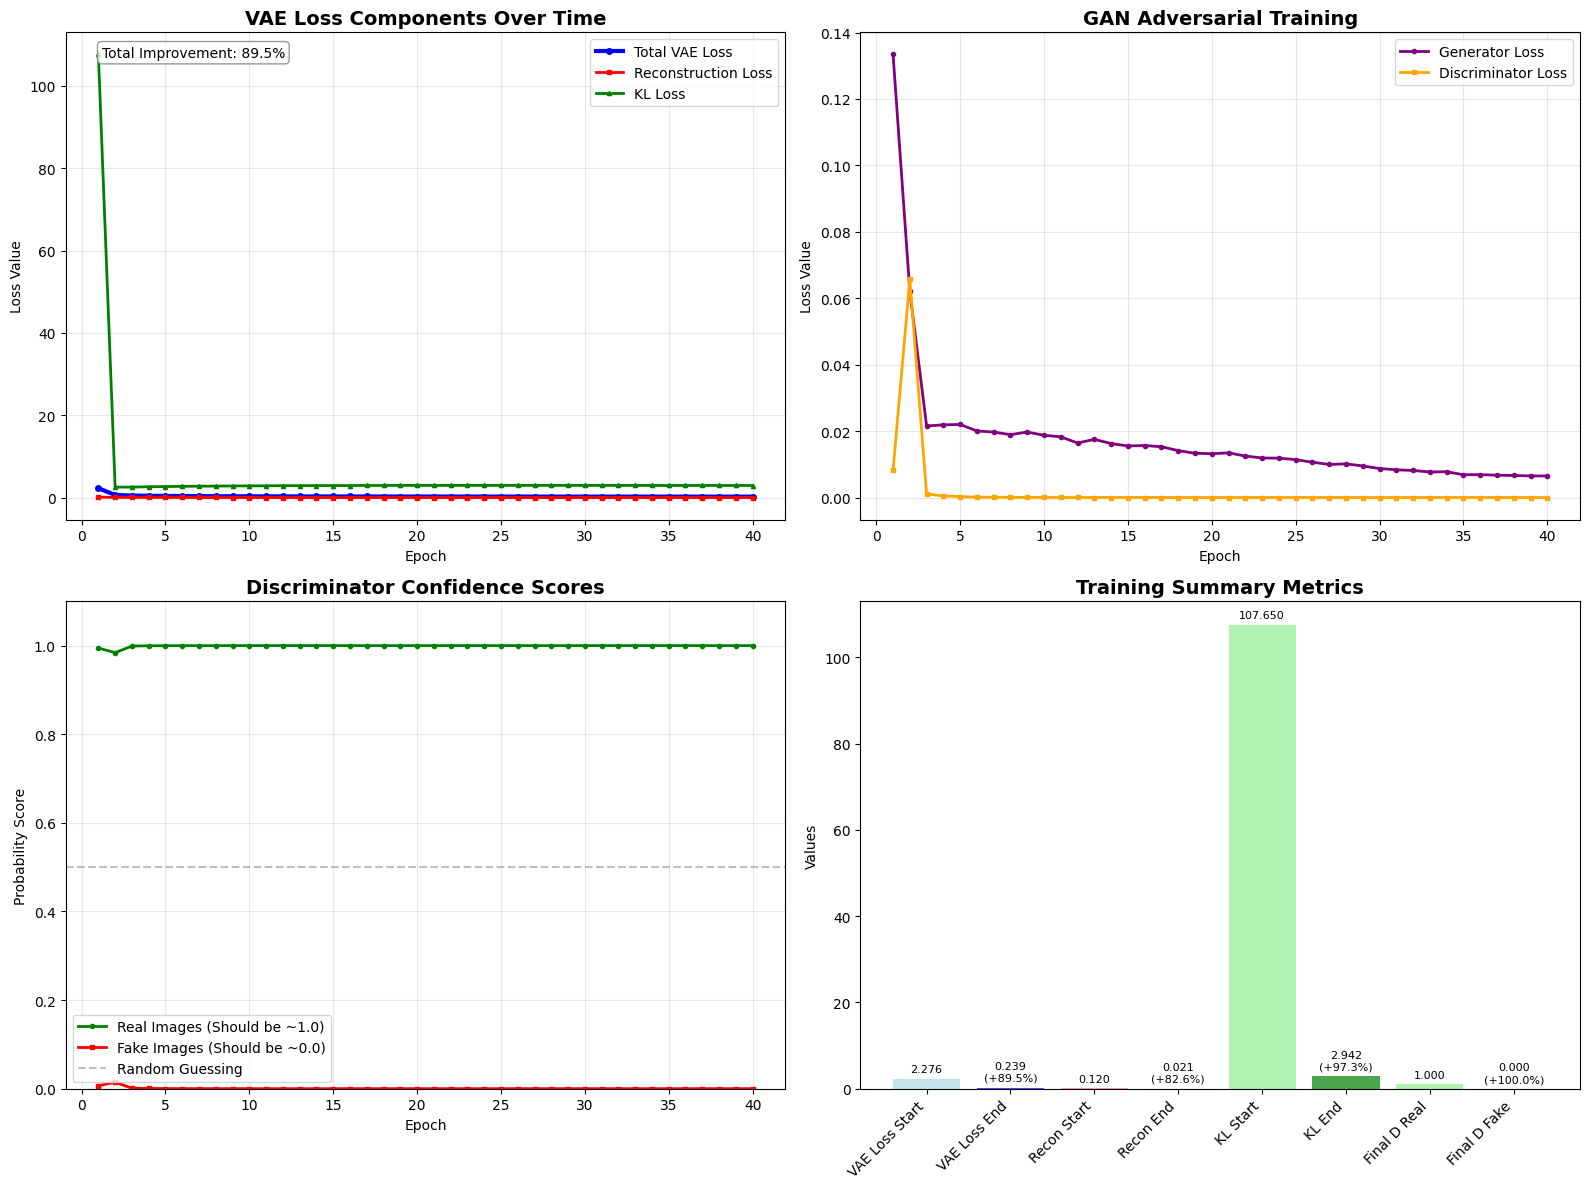


COMPREHENSIVE TRAINING ANALYSIS

 KEY METRICS:
   • VAE Loss: 2.276 → 0.239 (+89.5%)
   • Recon Loss: 0.120 → 0.021 (+82.6%)
   • KL Loss: 107.650 → 2.942
   • Training Epochs: 40

 TRAINING HEALTH CHECK:
     Reconstruction loss getting low - monitor carefully
    KL loss at good level
   GAN training well balanced
    Training may have plateaued

 VAE insights:
   • Excellent progress! Consider stopping soon (diminishing returns)
Generating latent space interpolations...
Found 202599 images using pattern: ./data/celeba/img_align_celeba/img_align_celeba/*.jpg
Using 20000 images for training
Latent interpolation saved

TRAINING COMPLETED SUCCESSFULLY!

Generated Deliverables:
Done! celeba_results_epoch_*.png - Real vs Reconstructed faces
Done! celeba_training_curves.png - All training losses
Done! celeba_latent_interpolation.png - Face morphing
Done! checkpoint_epoch_*.pth - Model checkpoints
Done! celeba_final_model.pth - Final trained model


In [ ]:
# Main execution
if __name__ == "__main__":
    os.makedirs('./results', exist_ok=True)

    print("=== VAE-GAN Hybrid Model on CelebA Faces ===")
    print(f"Device: {device}")

    try:
        # Train the model (now returns 3 values)
        trained_model, training_history, fixed_imgs = train_vaegan()

        print("Plotting training curves...")
        plot_training_curves(training_history)

        print("Creating comprehensive training analysis...")
        create_comprehensive_training_analysis(training_history)
        print("Generating latent space interpolations...")
        dataloader = get_celeba_dataloader()
        latent_space_interpolation(trained_model, dataloader)

        # Save final model
        torch.save({
            'model_state_dict': trained_model.state_dict(),
            'config': Config().__dict__,
            'training_history': training_history,
            'fixed_visualization_imgs': fixed_imgs
        }, './results/celeba_final_model.pth')

        print("\n" + "="*50)
        print("TRAINING COMPLETED SUCCESSFULLY!")
        print("="*50)
        print("\nGenerated Deliverables:")
        print("Done! celeba_results_epoch_*.png - Real vs Reconstructed faces")
        print("Done! celeba_training_curves.png - All training losses")
        print("Done! celeba_latent_interpolation.png - Face morphing")
        print("Done! checkpoint_epoch_*.pth - Model checkpoints")
        print("Done! celeba_final_model.pth - Final trained model")

    except Exception as e:
        print(f"Training failed: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
def save_technical_report(history, filename='./results/comprehensive_technical_report.txt'):
    vae_improvement = ((history['vae_loss'][0] - history['vae_loss'][-1]) / history['vae_loss'][0]) * 100
    recon_improvement = ((history['recon_loss'][0] - history['recon_loss'][-1]) / history['recon_loss'][0]) * 100

    with open(filename, 'w') as f:
        f.write("=== VAE-GAN Comprehensive Technical Report ===\n\n")
        f.write(f"Training Epochs: {len(history['vae_loss'])}\n\n")
        f.write("KEY METRICS:\n")
        f.write(f"  • VAE Loss: {history['vae_loss'][0]:.3f} → {history['vae_loss'][-1]:.3f} ({vae_improvement:+.1f}%)\n")
        f.write(f"  • Recon Loss: {history['recon_loss'][0]:.3f} → {history['recon_loss'][-1]:.3f} ({recon_improvement:+.1f}%)\n")
        f.write(f"  • KL Loss: {history['kl_loss'][0]:.3f} → {history['kl_loss'][-1]:.3f}\n")
        f.write(f"  • Final Discriminator Scores: Real={history['d_real'][-1]:.3f}, Fake={history['d_fake'][-1]:.3f}\n\n")
        f.write("TRAINING INSIGHTS:\n")
        if vae_improvement > 50:
            f.write("  • Excellent VAE progress!\n")
        elif vae_improvement > 30:
            f.write("  • Good VAE progress\n")
        else:
            f.write("  • Moderate VAE progress\n")
        f.write("  • Check GAN balance and KL divergence as printed in analysis.\n")


In [ ]:
save_technical_report(training_history)


 PROJECT DELIVERABLES SUMMARY

 1. TRAINING PERFORMANCE SUMMARY:


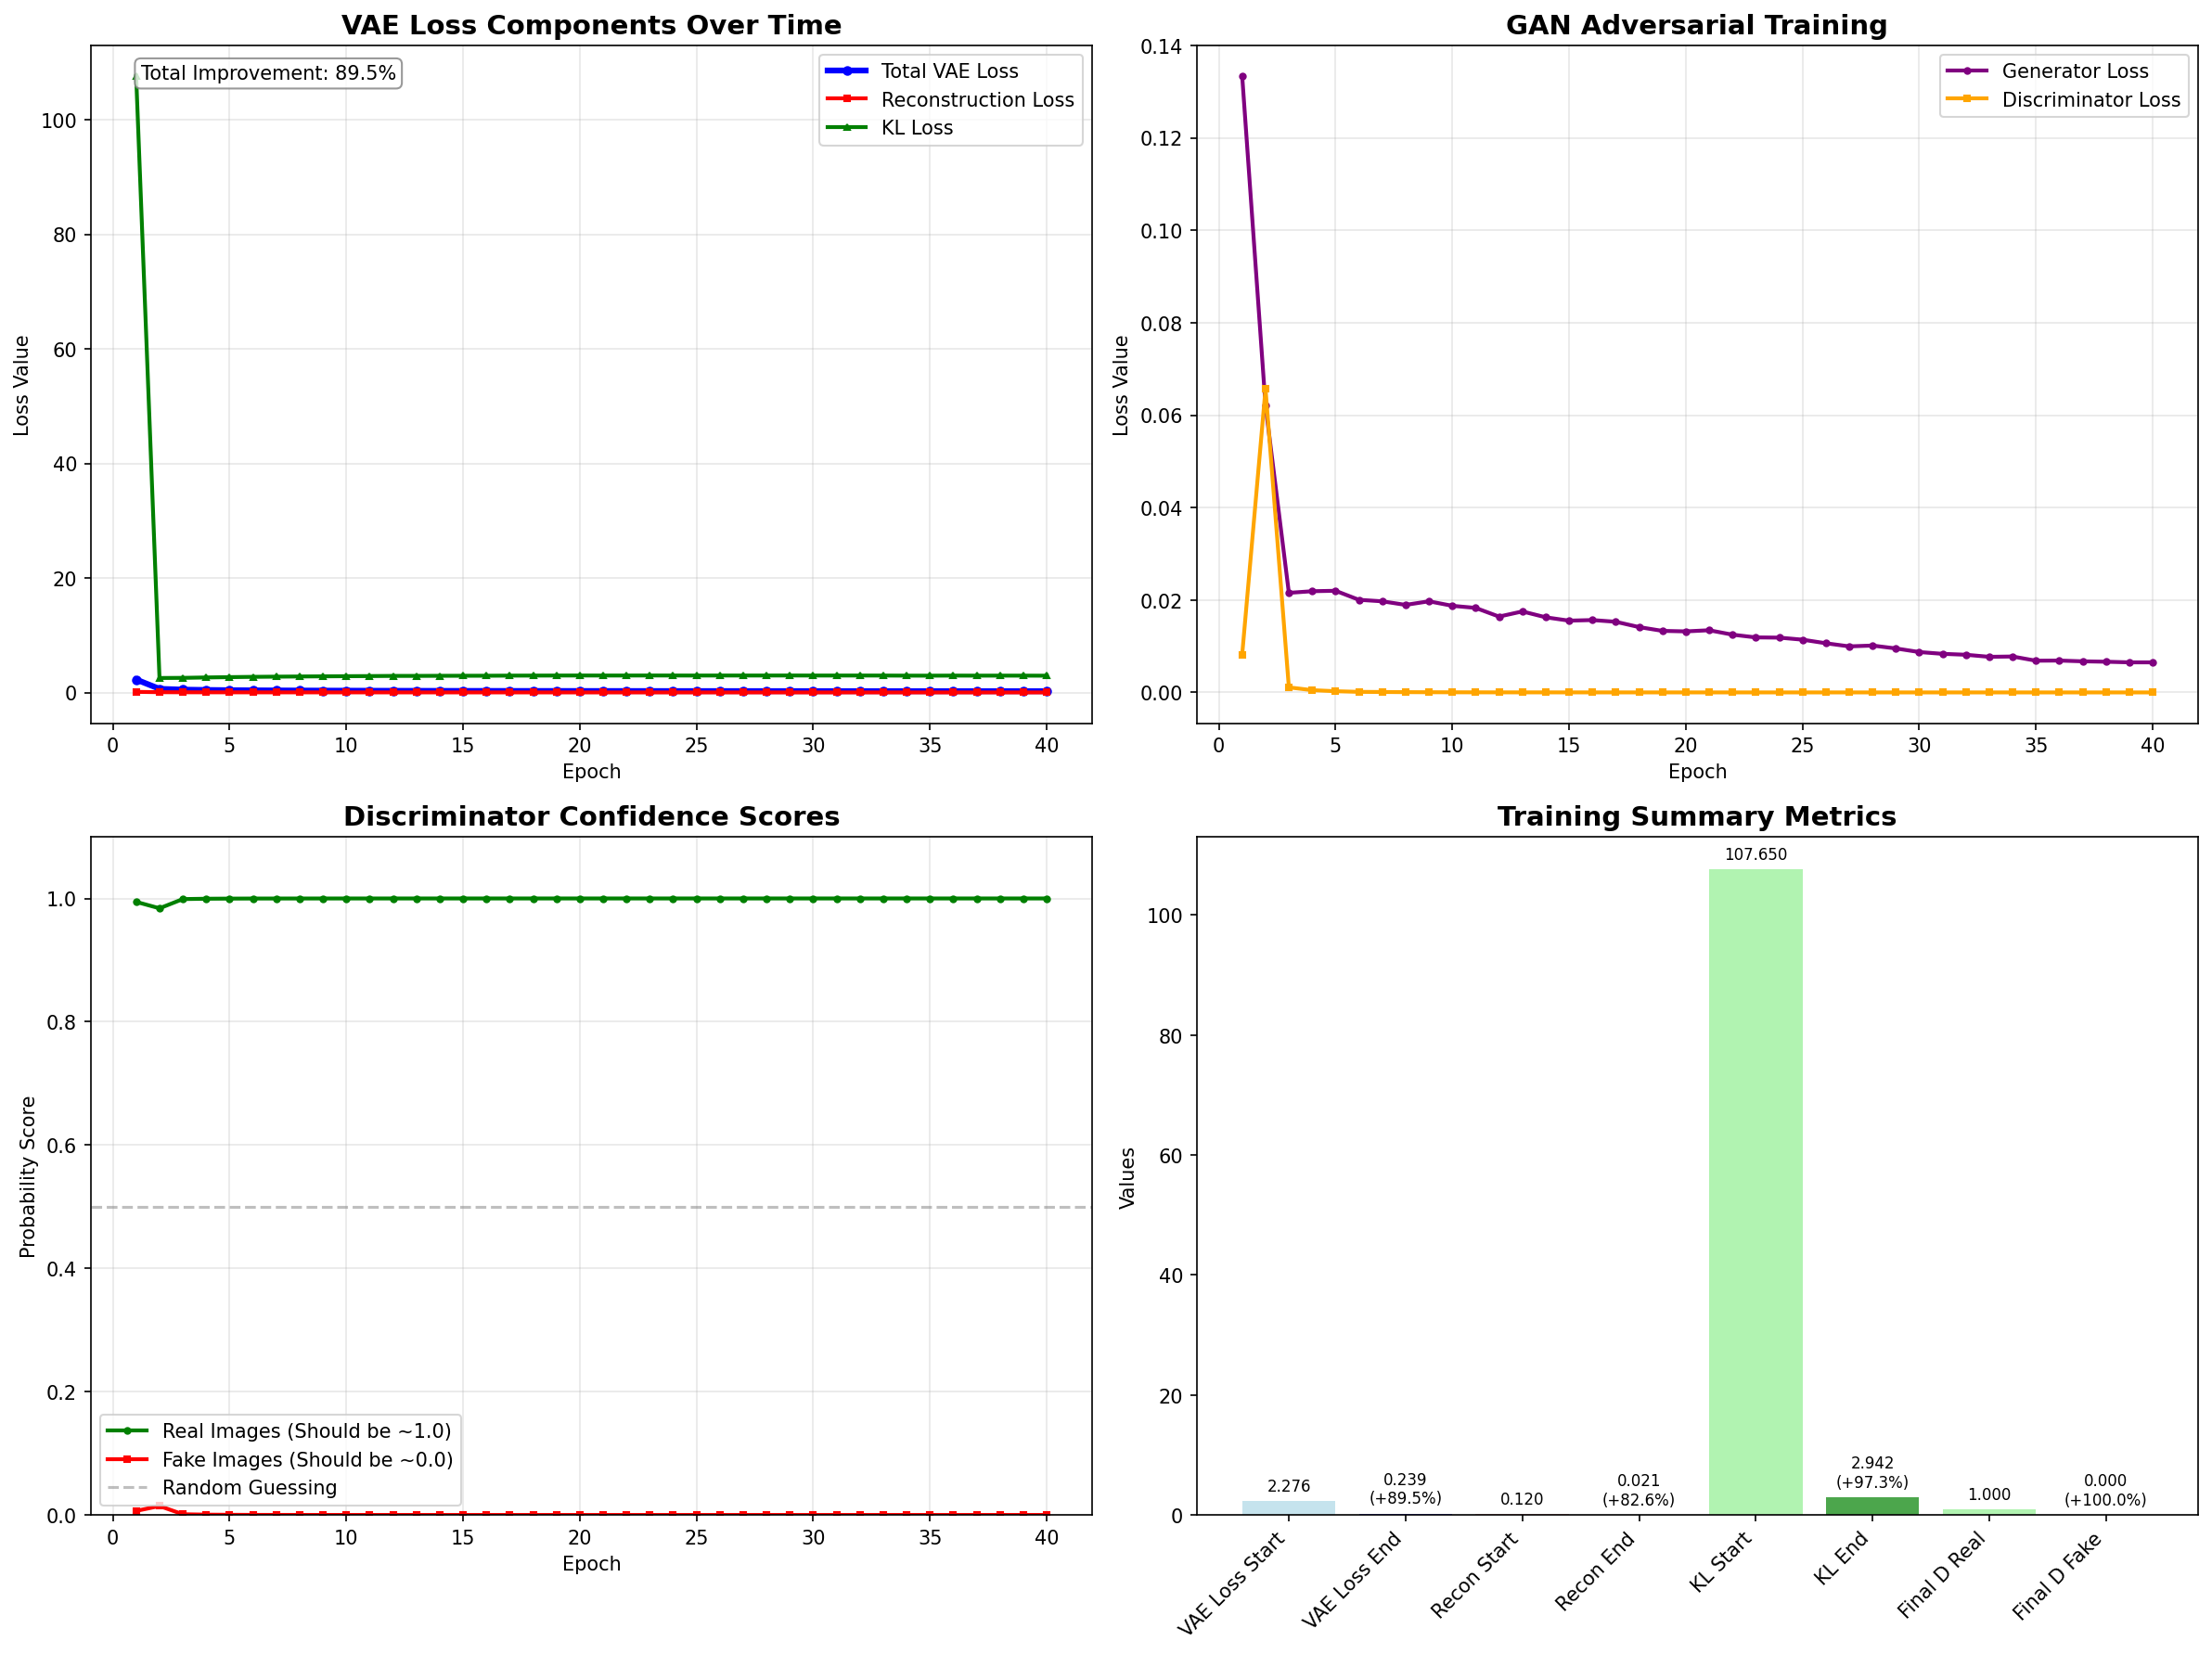


 2. DETAILED TRAINING CURVES:


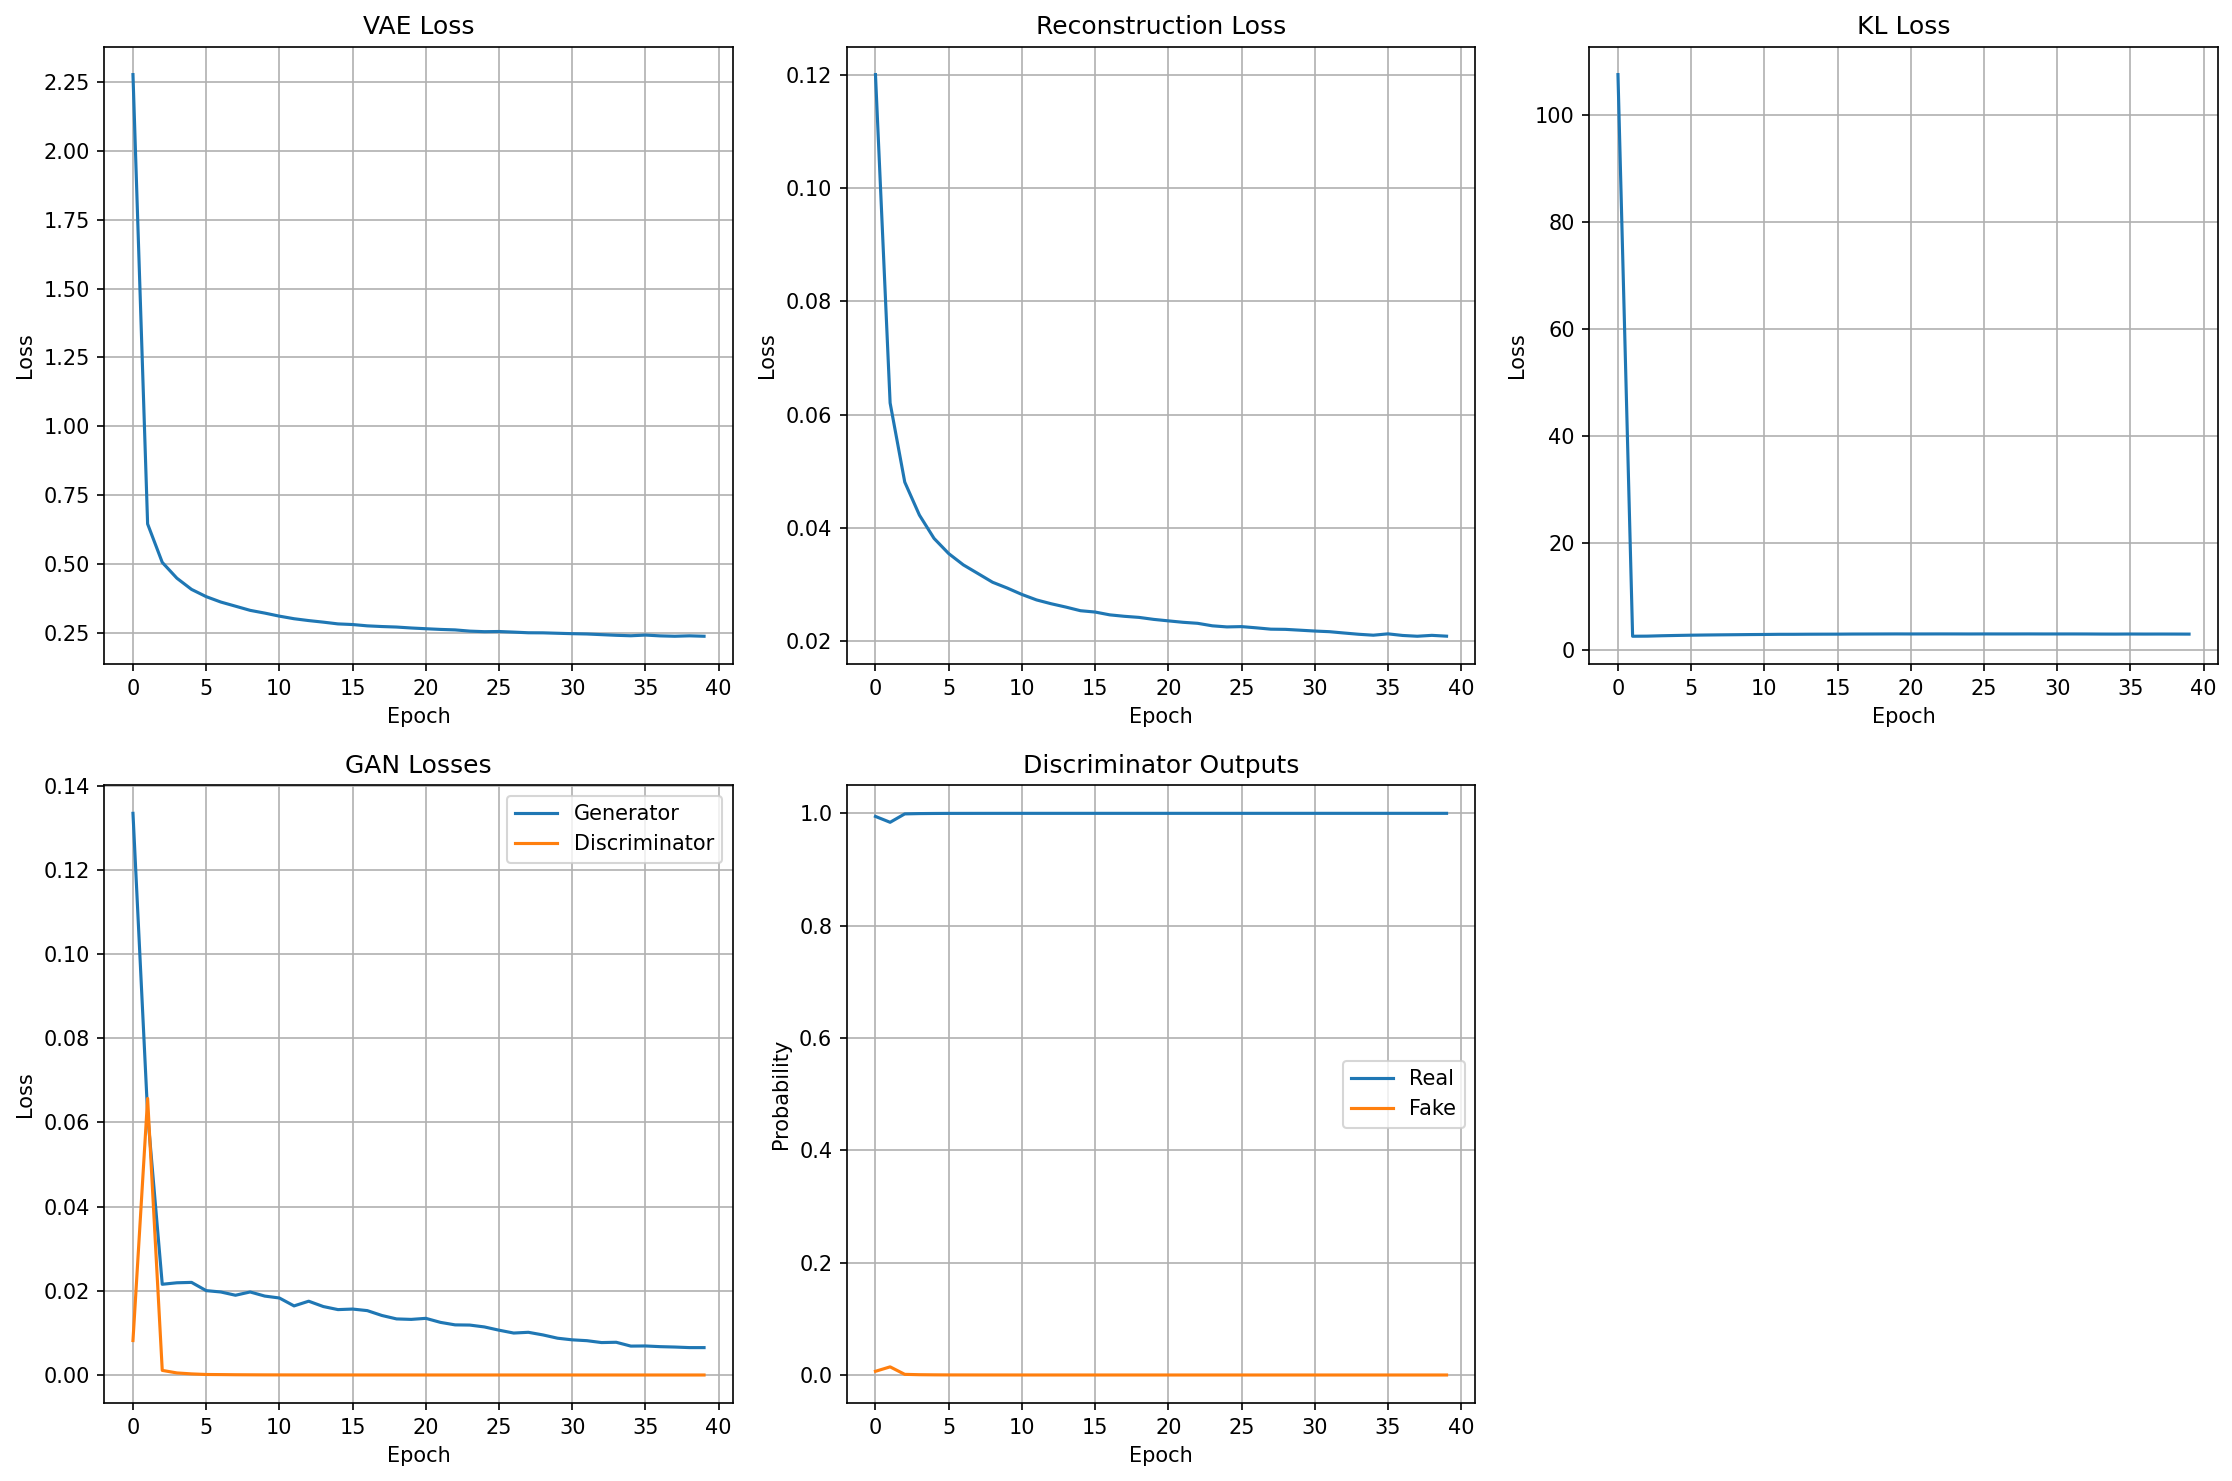


  3. PROGRESSIVE RECONSTRUCTION QUALITY:
   Epoch 1:


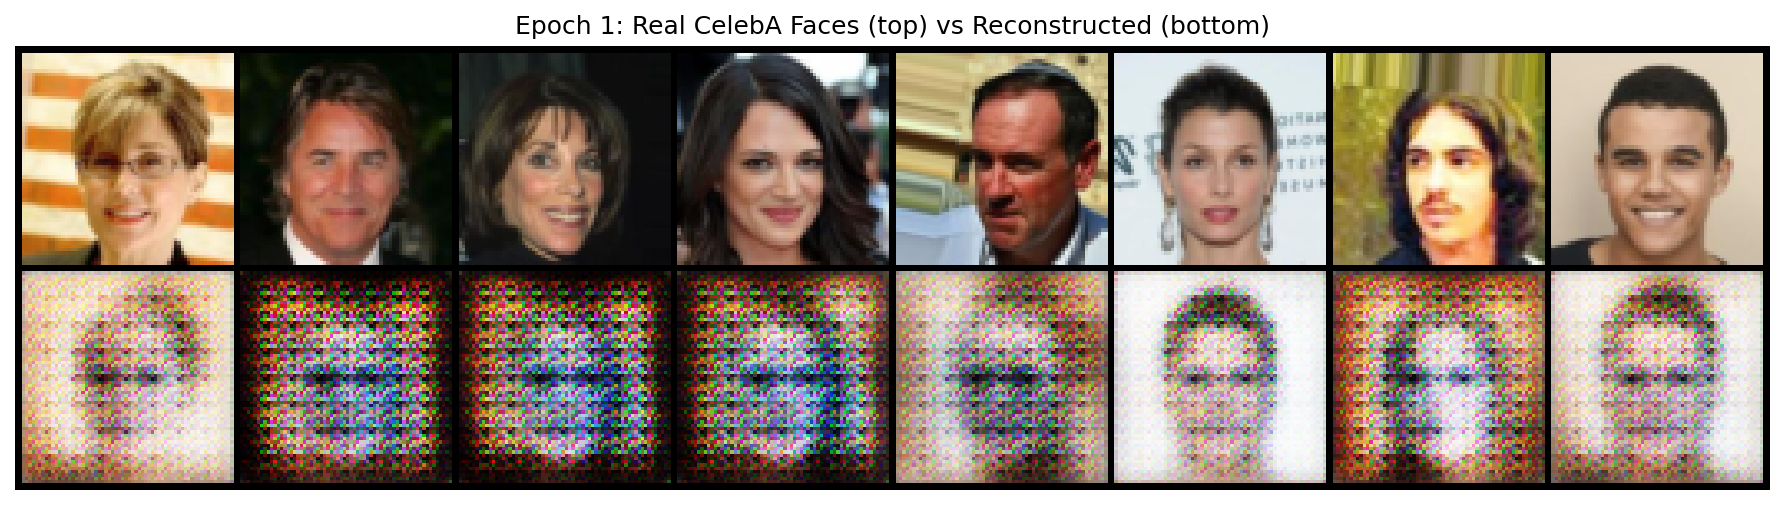

   Epoch 5:


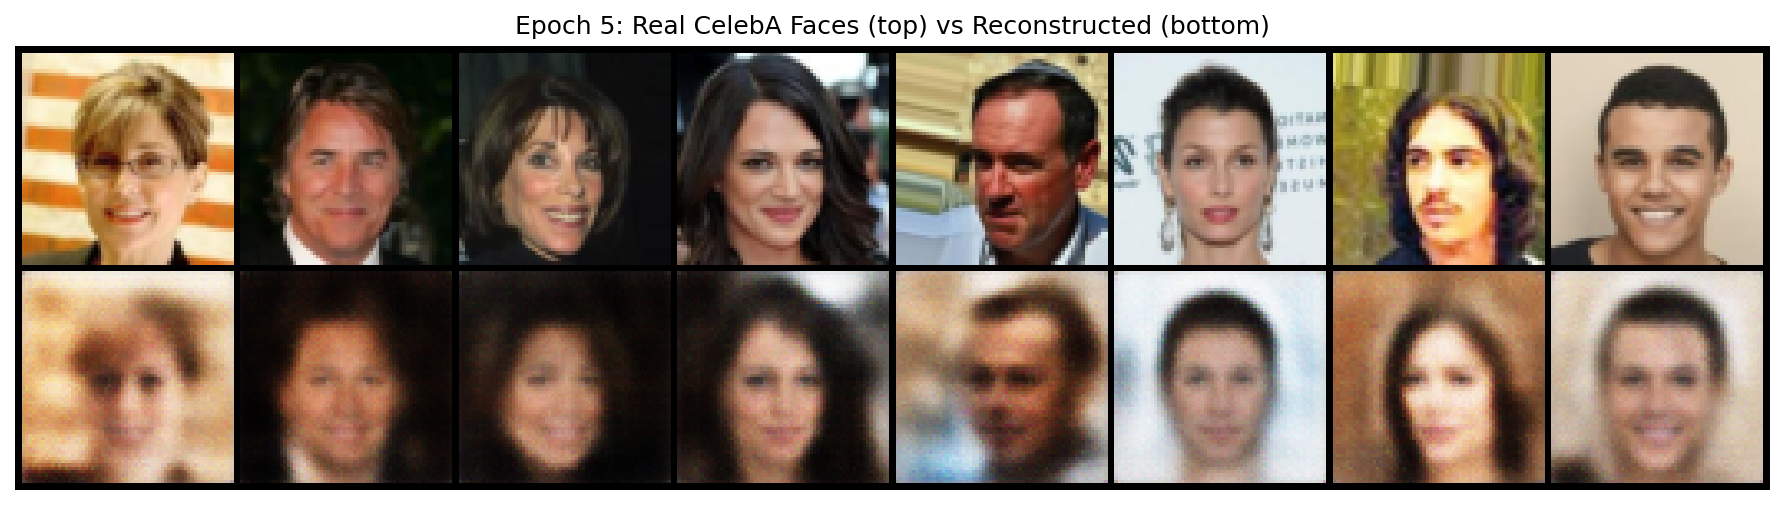

   Epoch 10:


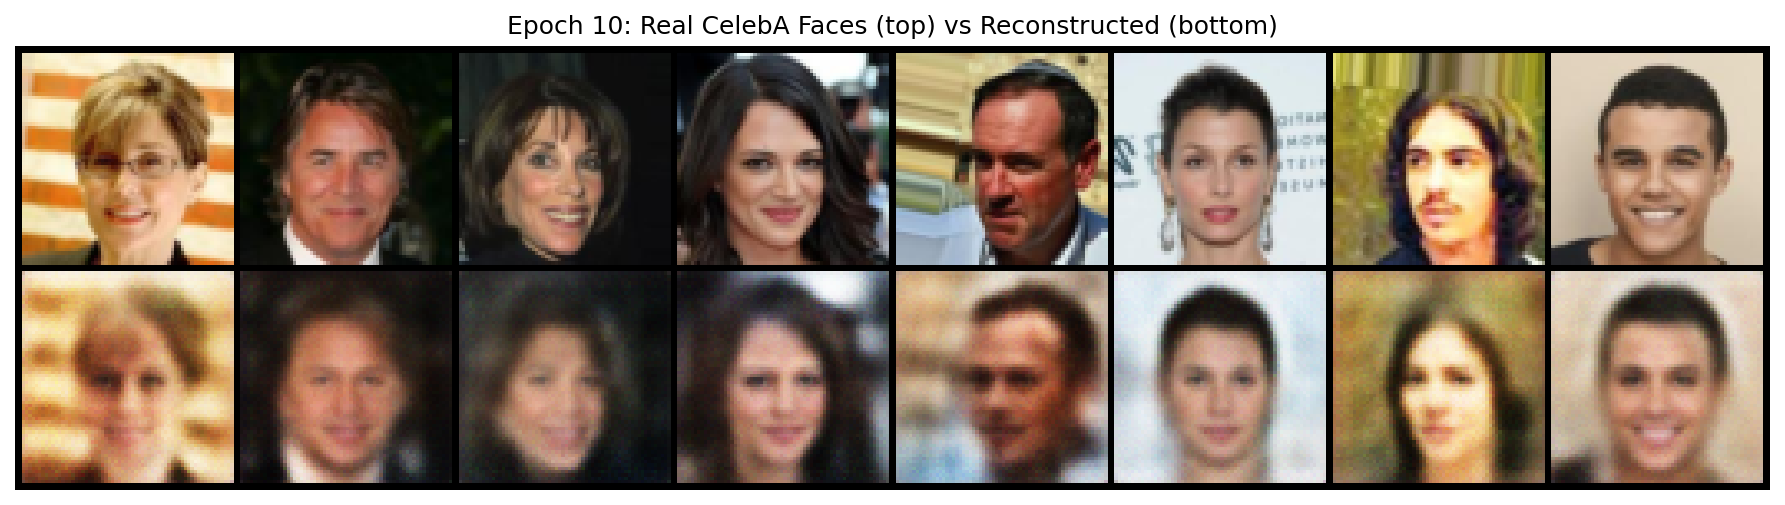

   Epoch 15:


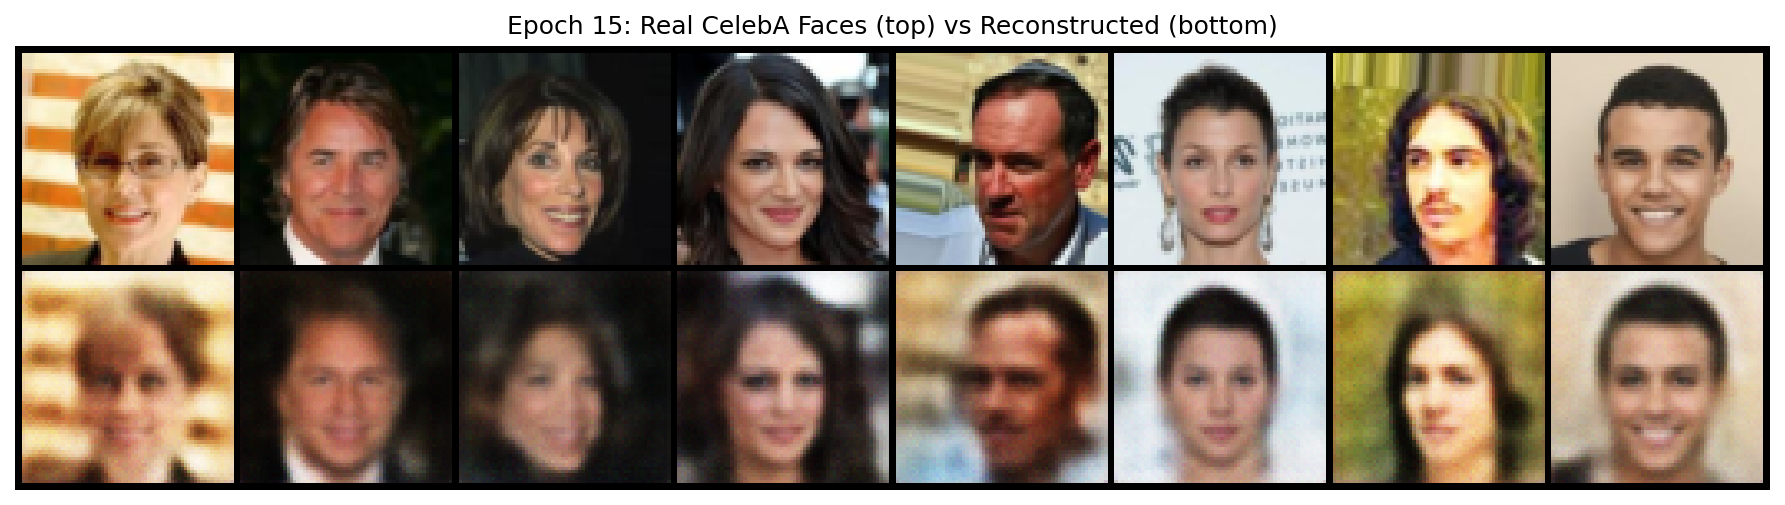

   Epoch 20:


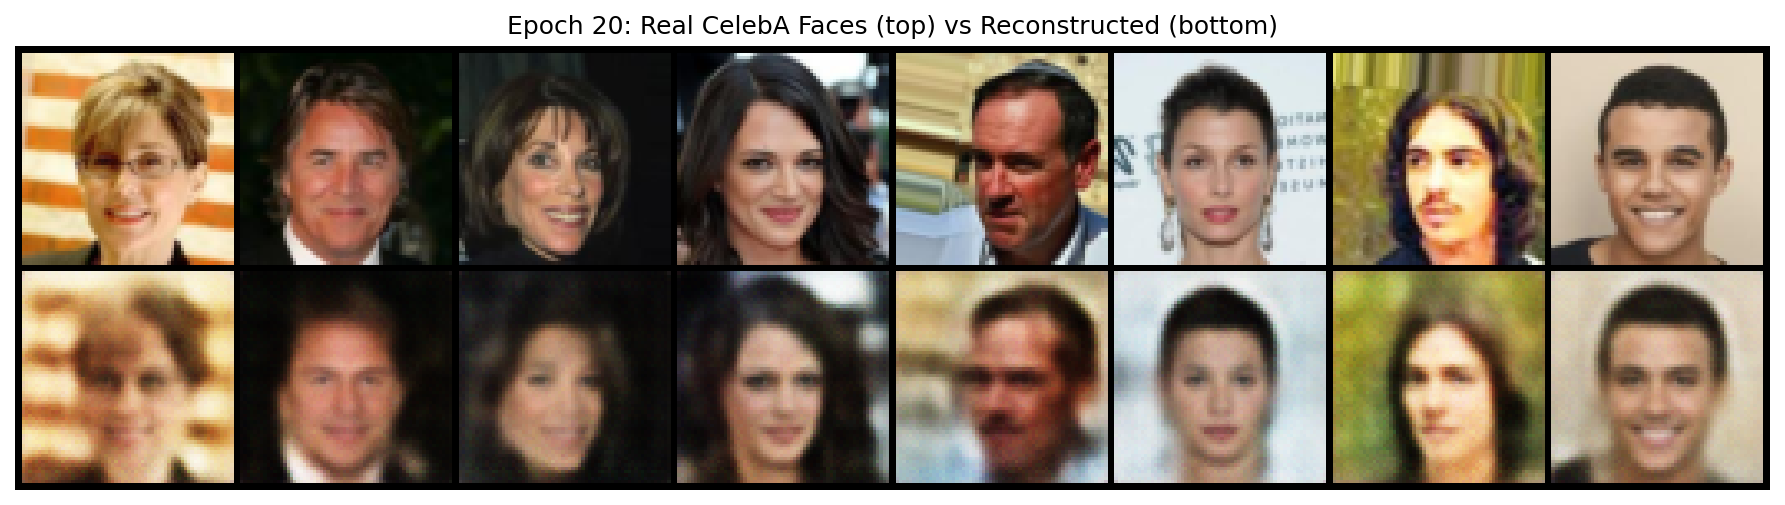

   Epoch 25:


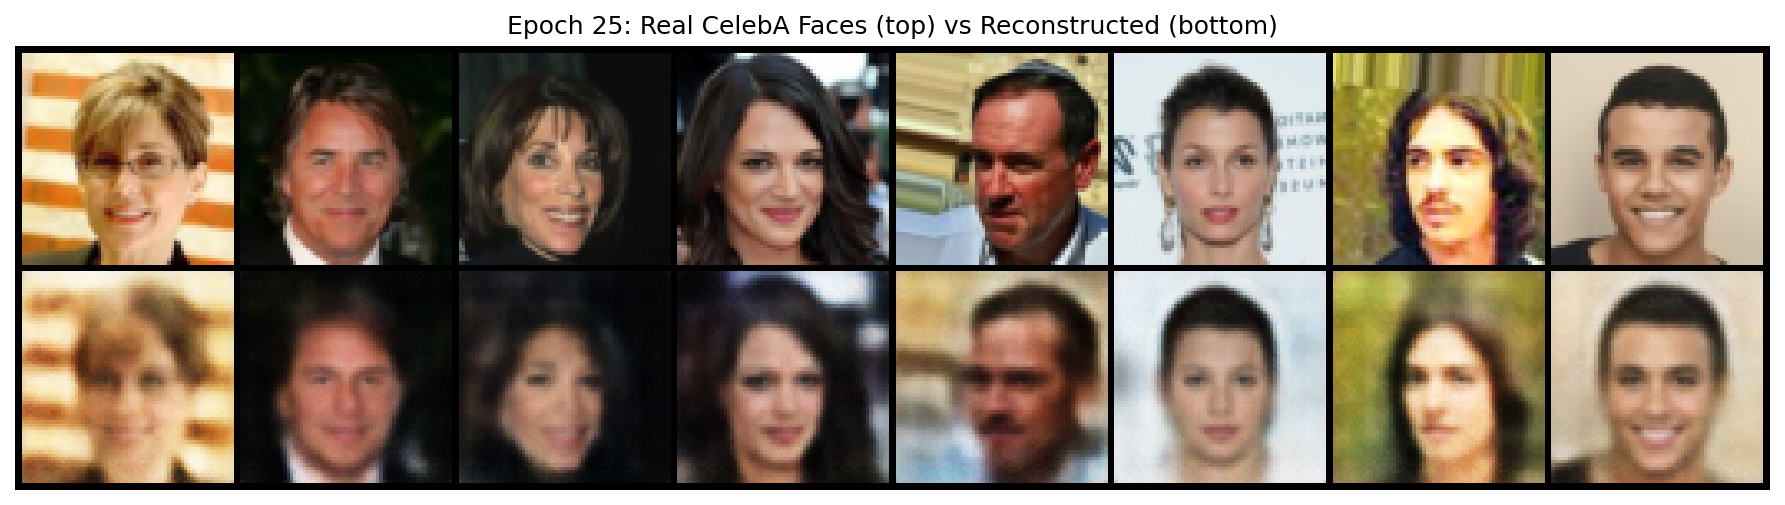

   Epoch 30:


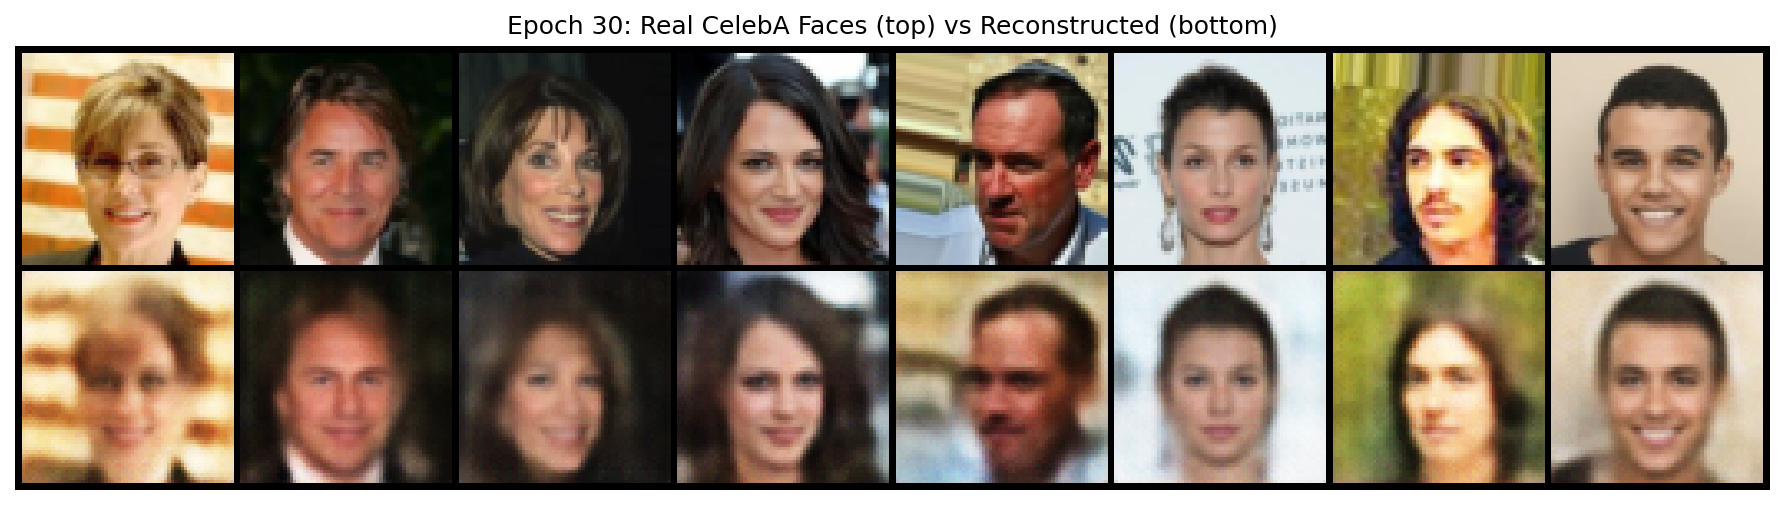

   Epoch 35:


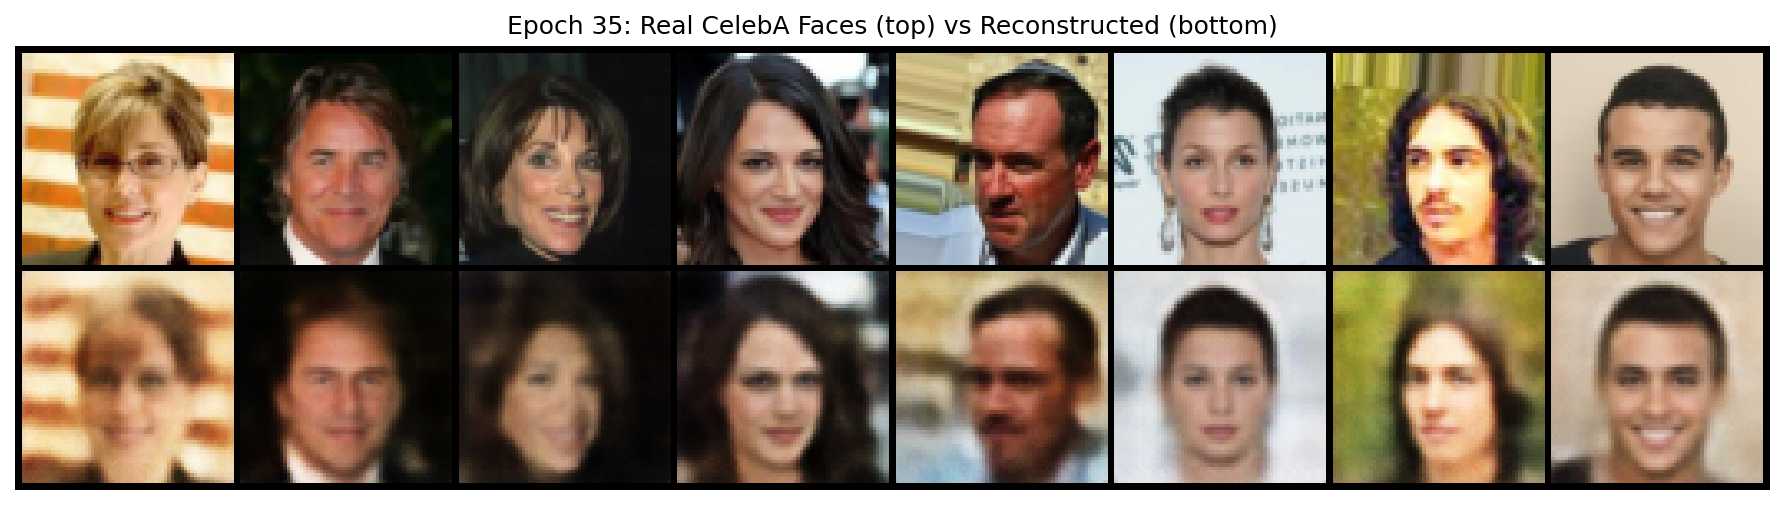

   Epoch 40:


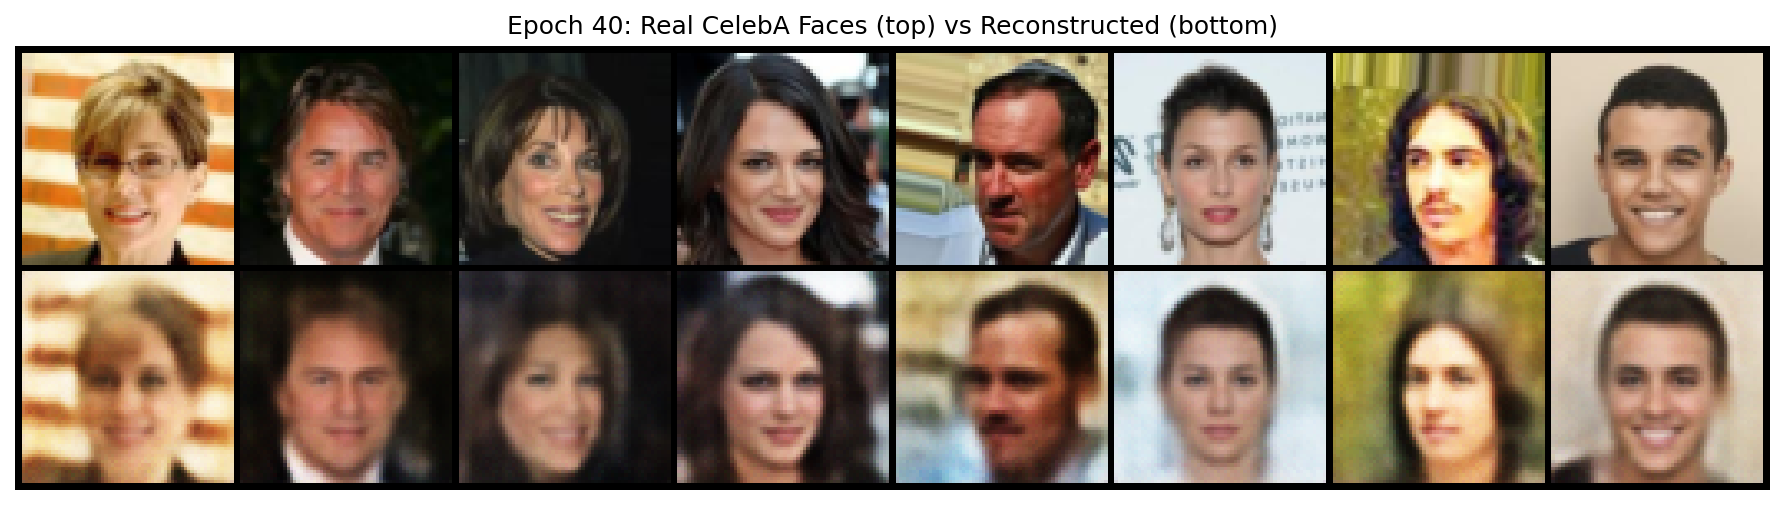


 4. LATENT SPACE INTERPOLATION (Face Morphing):


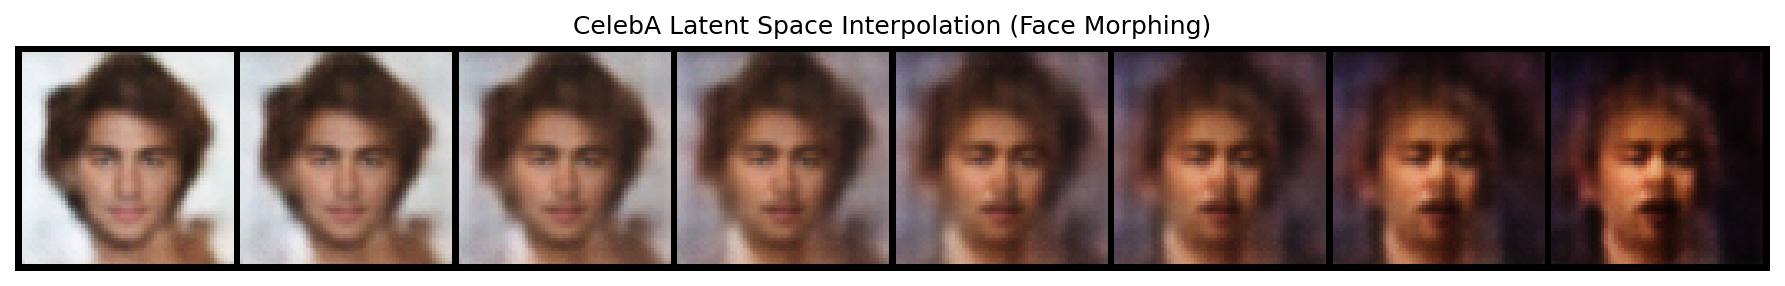


 TECHNICAL REPORT SUMMARY:
=== VAE-GAN Comprehensive Technical Report ===

Training Epochs: 40

KEY METRICS:
  • VAE Loss: 2.276 → 0.239 (+89.5%)
  • Recon Loss: 0.120 → 0.021 (+82.6%)
  • KL Loss: 107.650 → 2.942
  • Final Discriminator Scores: Real=1.000, Fake=0.000

TRAINING INSIGHTS:
  • Excellent VAE progress!
  • Check GAN balance and KL divergence as printed in analysis.



In [ ]:
# DISPLAY ALL DELIVERABLES
def display_all_deliverables():
    """Display all generated deliverables for the project"""

    from IPython.display import Image, display, Markdown
    import glob

    print(" PROJECT DELIVERABLES SUMMARY")
    print("=" * 60)

    # 1. Show training performance summary
    print("\n 1. TRAINING PERFORMANCE SUMMARY:")
    display(Image(filename='./results/comprehensive_training_analysis.png'))

    # 2. Show main training curves
    print("\n 2. DETAILED TRAINING CURVES:")
    display(Image(filename='./results/celeba_training_curves.png'))

    # 3. Show progressive reconstructions
    print("\n  3. PROGRESSIVE RECONSTRUCTION QUALITY:")
    result_files = sorted(glob.glob('./results/celeba_results_epoch_*.png'))
    # Show key epochs: 1, 10, 20, 30, 40
    key_epochs = [1,5, 10,15, 20, 25,30, 35, 40]
    for epoch in key_epochs:
        file = f'./results/celeba_results_epoch_{epoch}.png'
        if os.path.exists(file):
            print(f"   Epoch {epoch}:")
            display(Image(filename=file))

    # 4. Show latent space interpolation
    print("\n 4. LATENT SPACE INTERPOLATION (Face Morphing):")
    display(Image(filename='./results/celeba_latent_interpolation.png'))

    # 5. Show technical report
    print("\n TECHNICAL REPORT SUMMARY:")
    with open('./results/comprehensive_technical_report.txt', 'r') as f:
        print(f.read())

# Run the display function
display_all_deliverables()

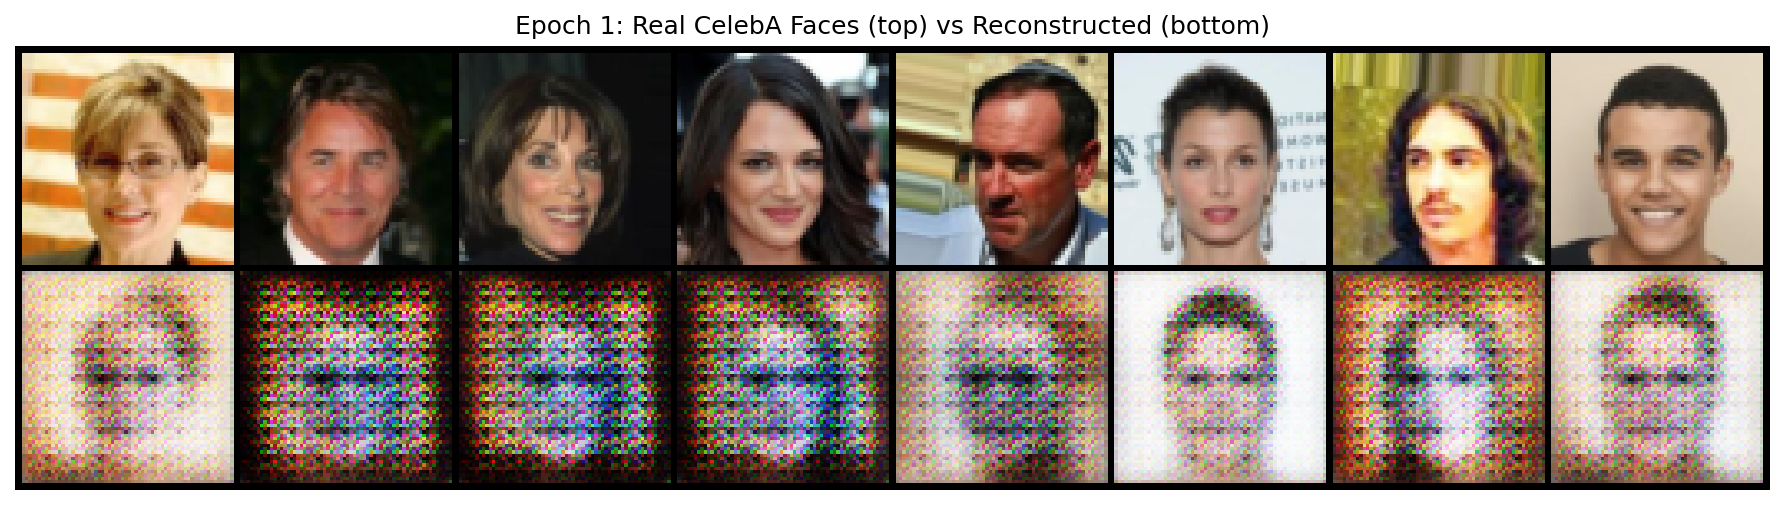

Displaying: ./results/celeba_results_epoch_1.png


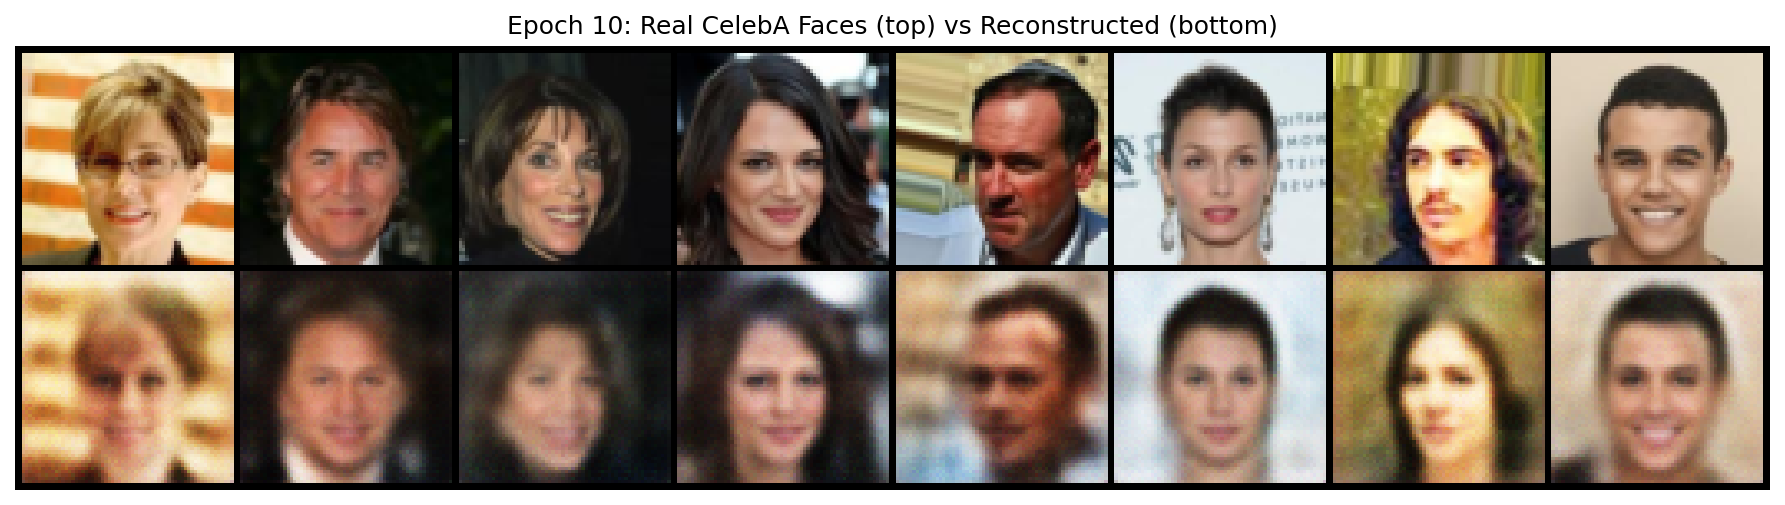

Displaying: ./results/celeba_results_epoch_10.png


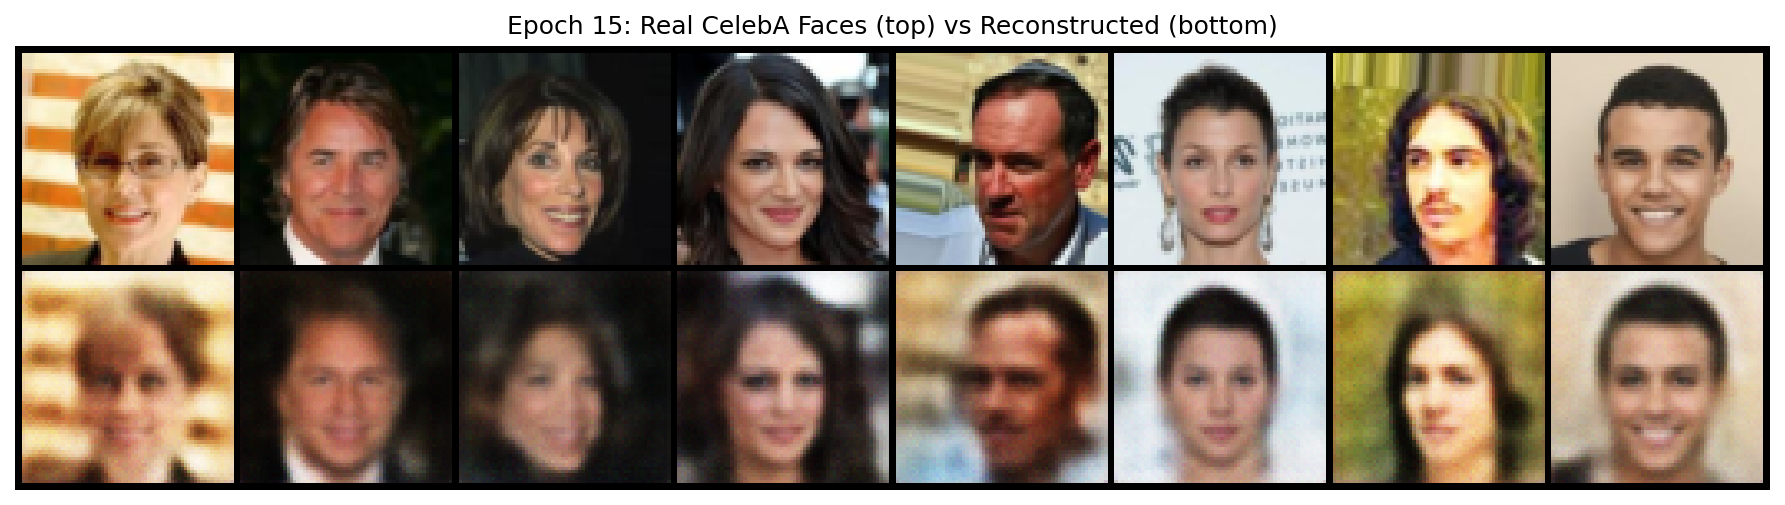

Displaying: ./results/celeba_results_epoch_15.png


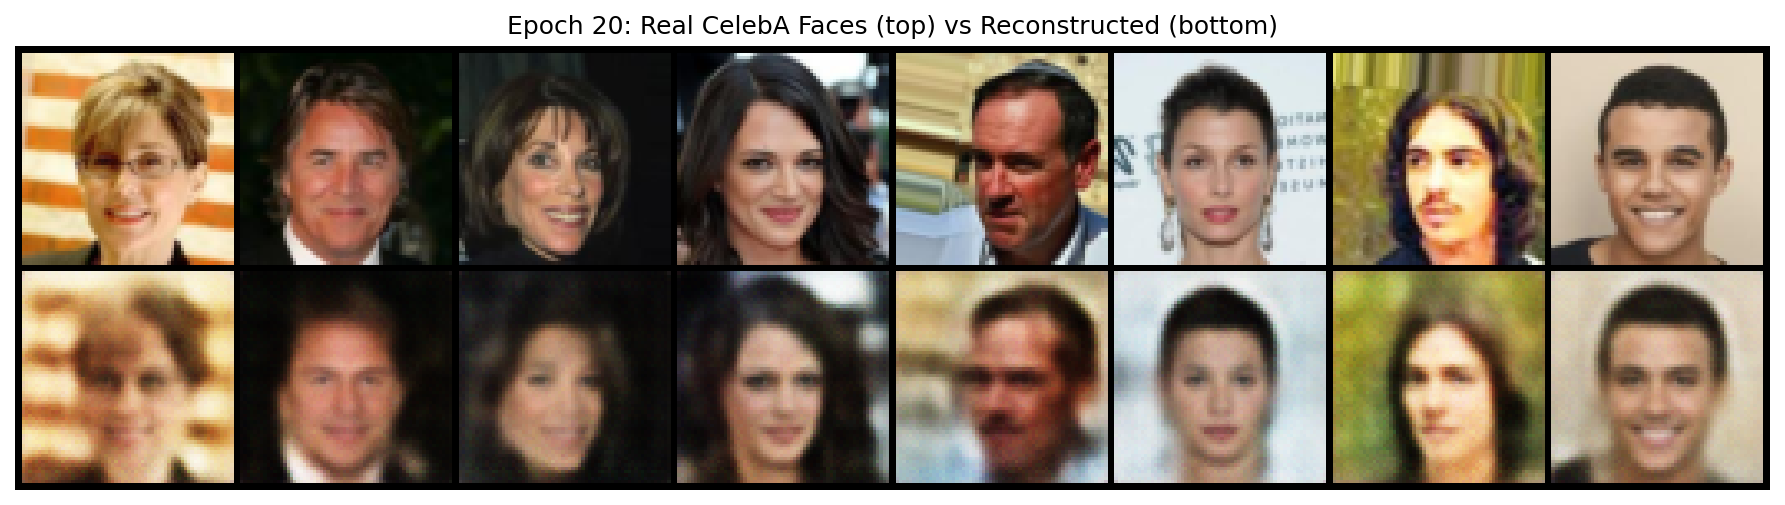

Displaying: ./results/celeba_results_epoch_20.png


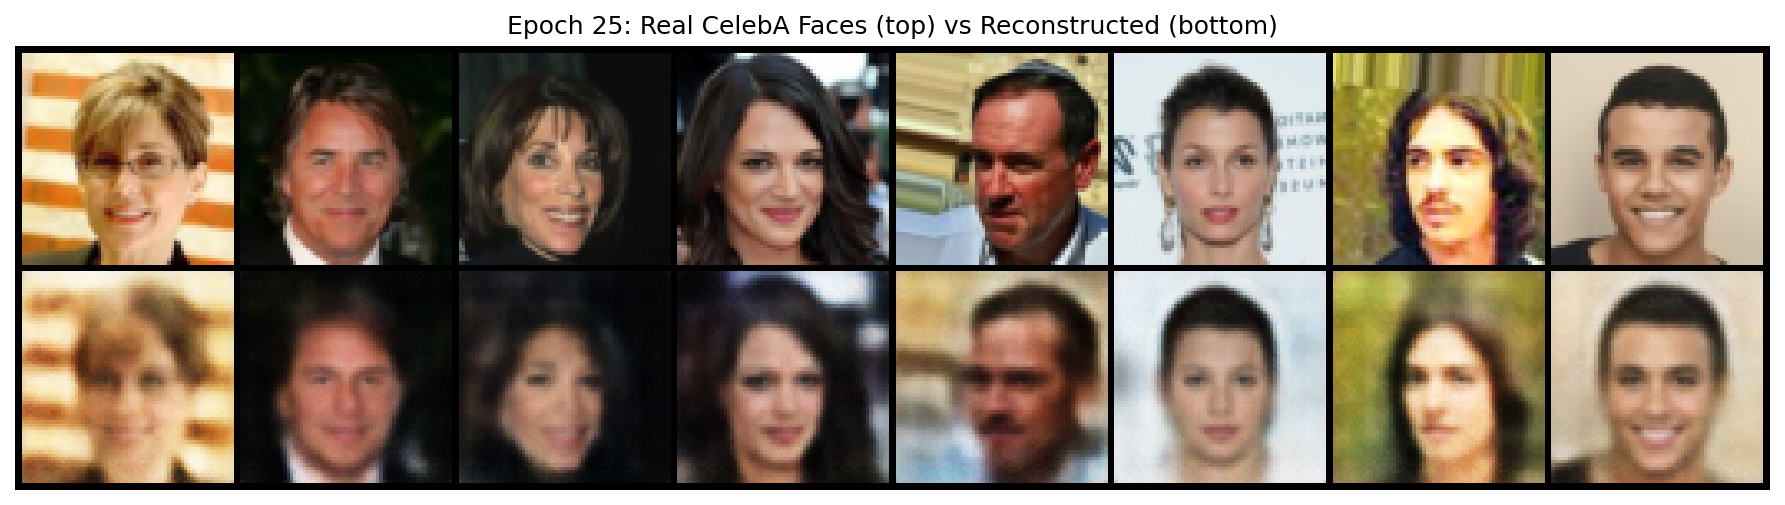

Displaying: ./results/celeba_results_epoch_25.png


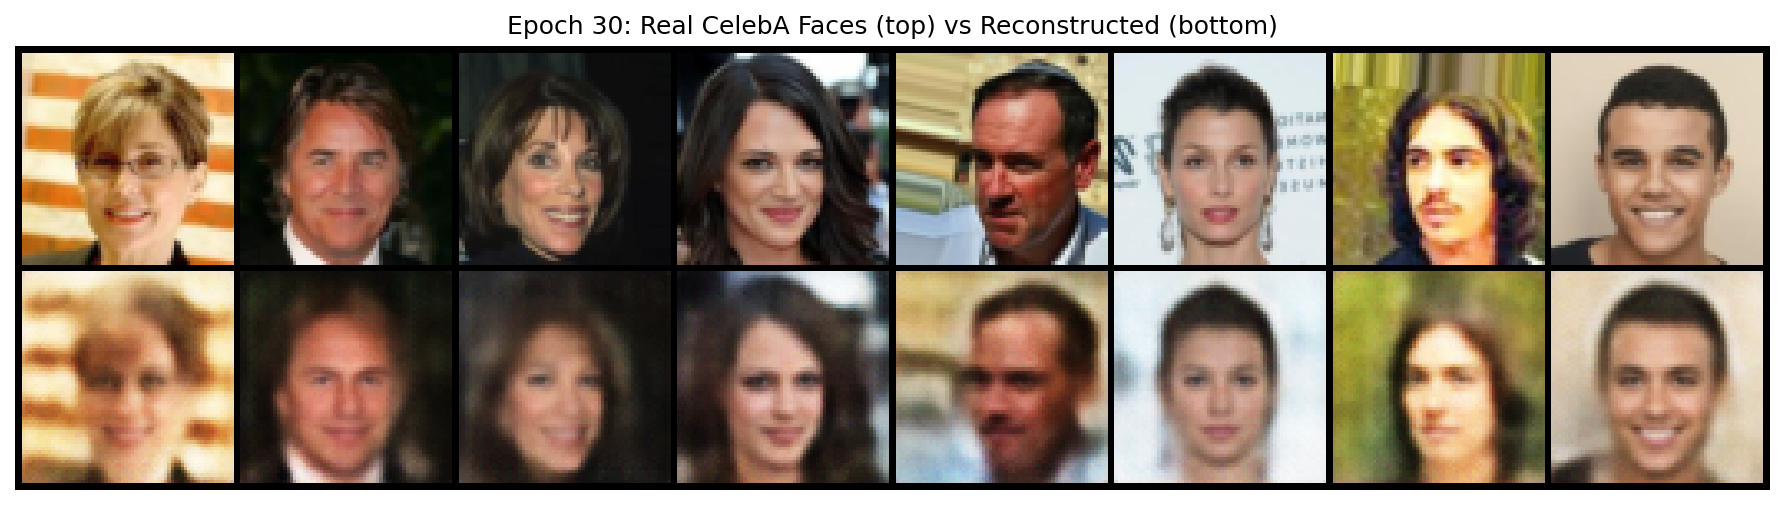

Displaying: ./results/celeba_results_epoch_30.png


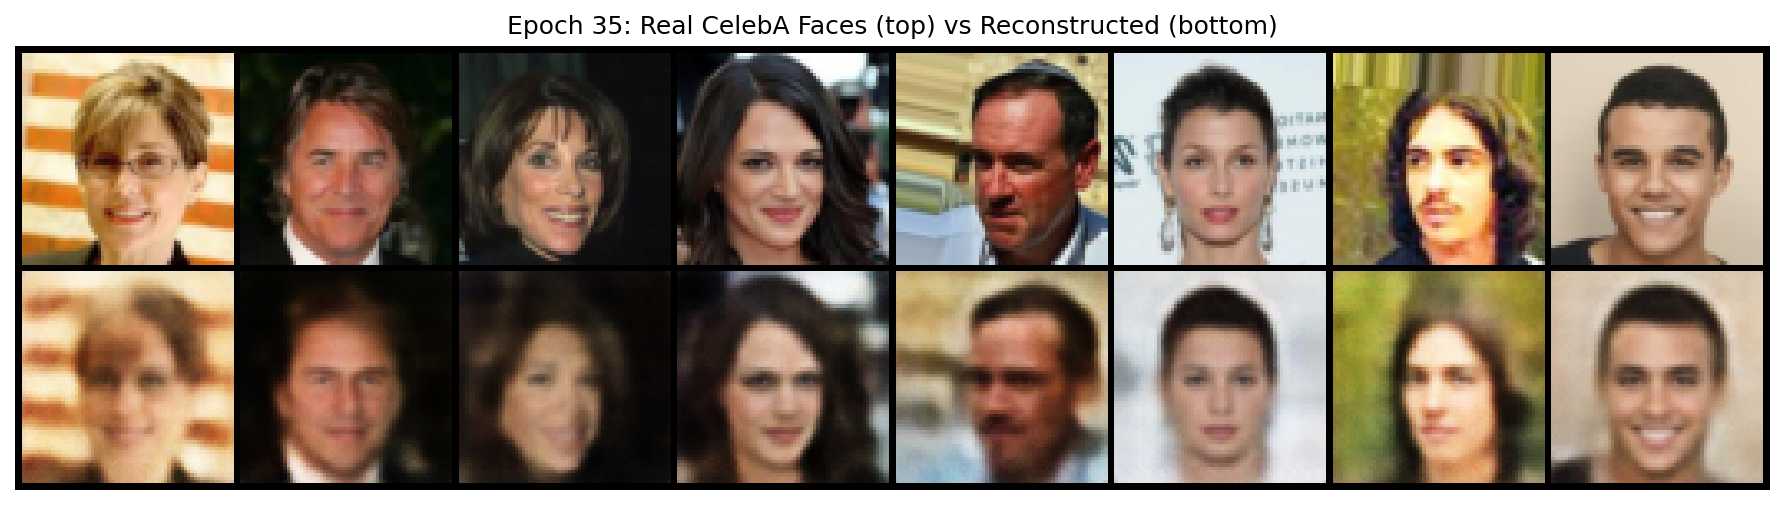

Displaying: ./results/celeba_results_epoch_35.png


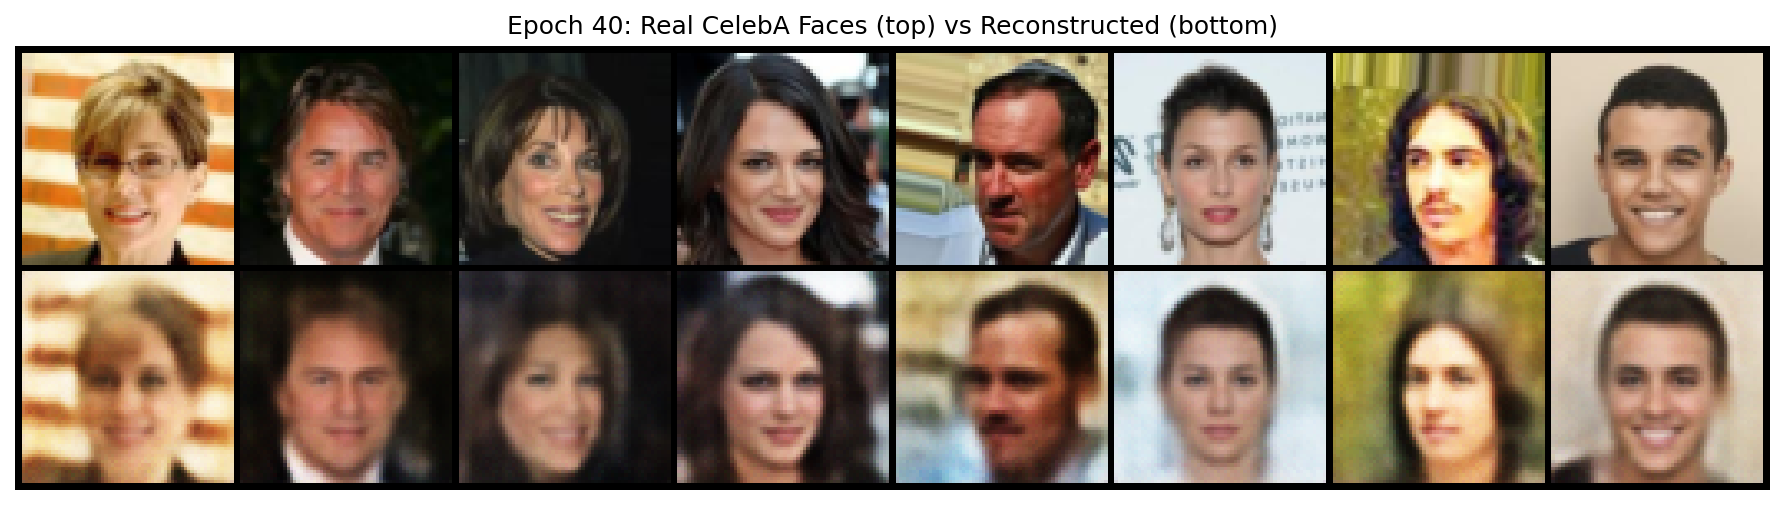

Displaying: ./results/celeba_results_epoch_40.png


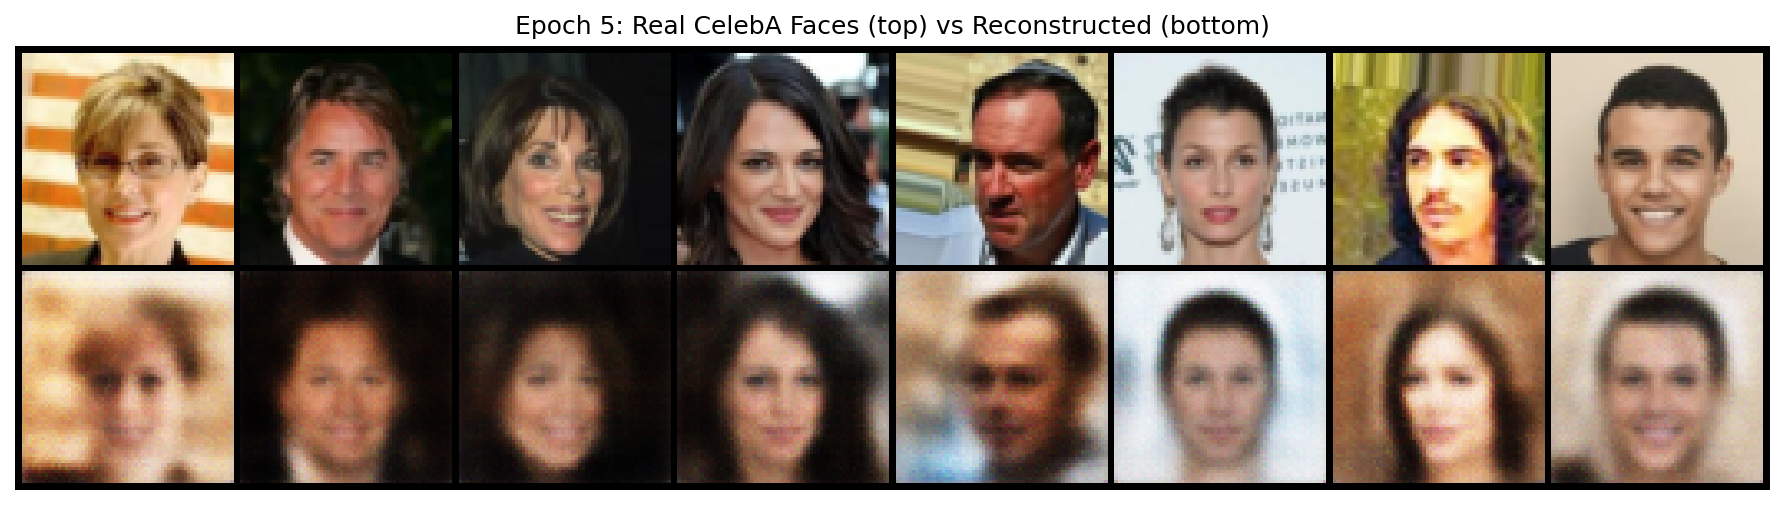

Displaying: ./results/celeba_results_epoch_5.png


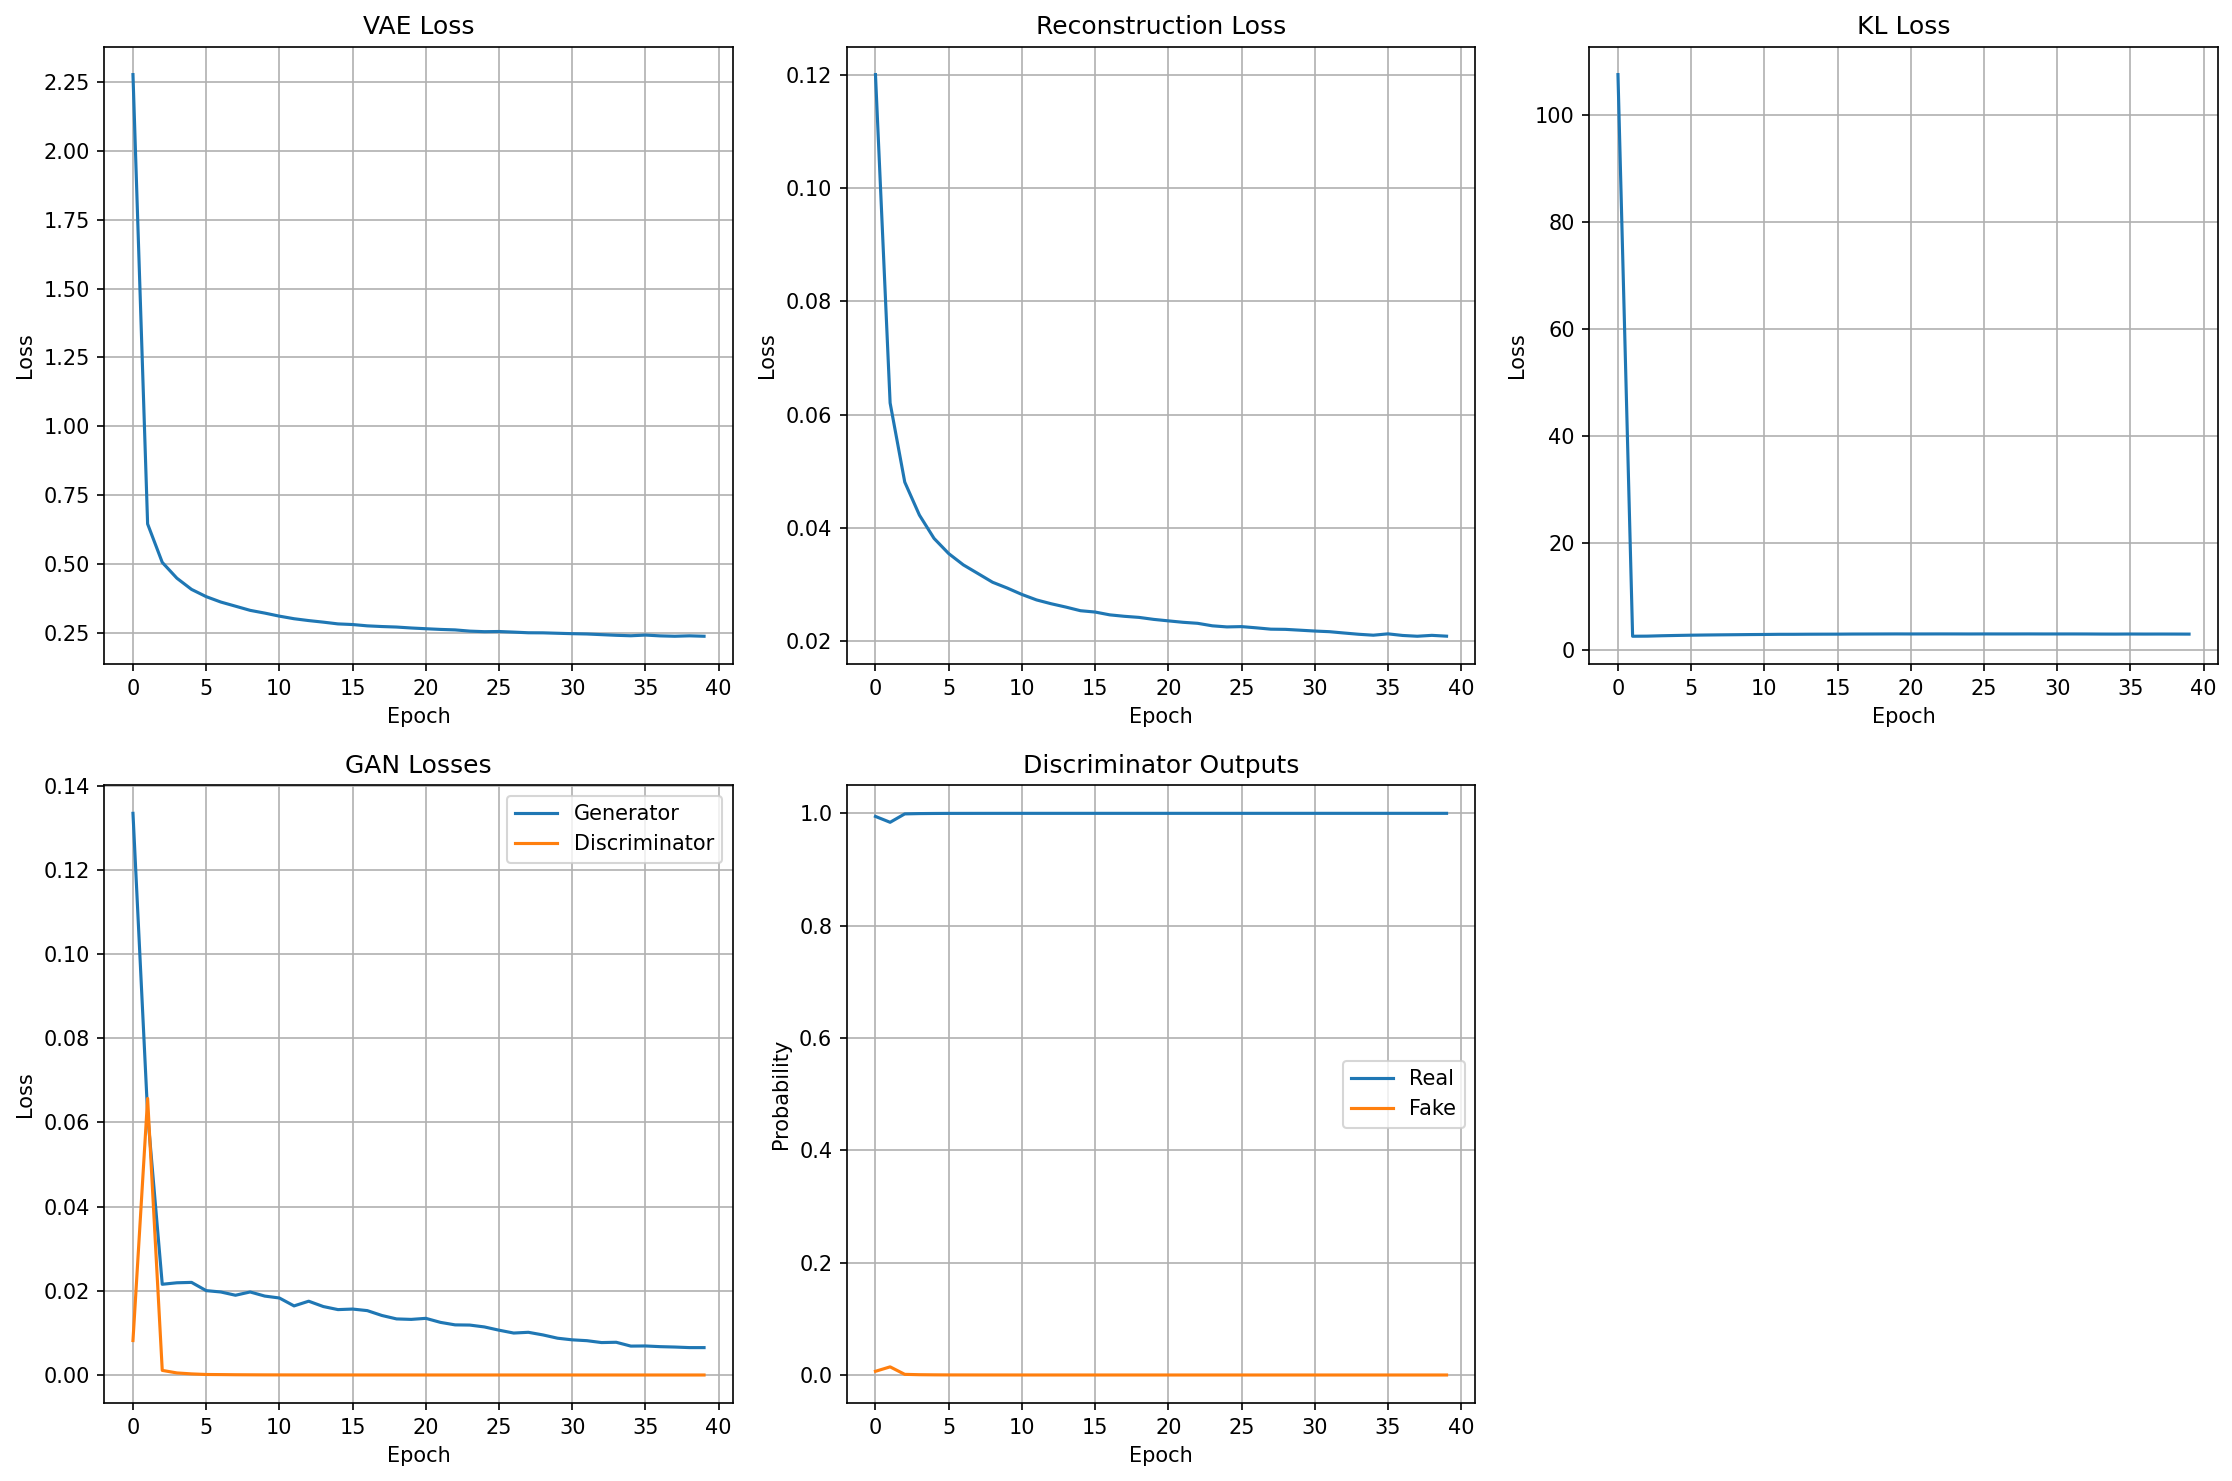

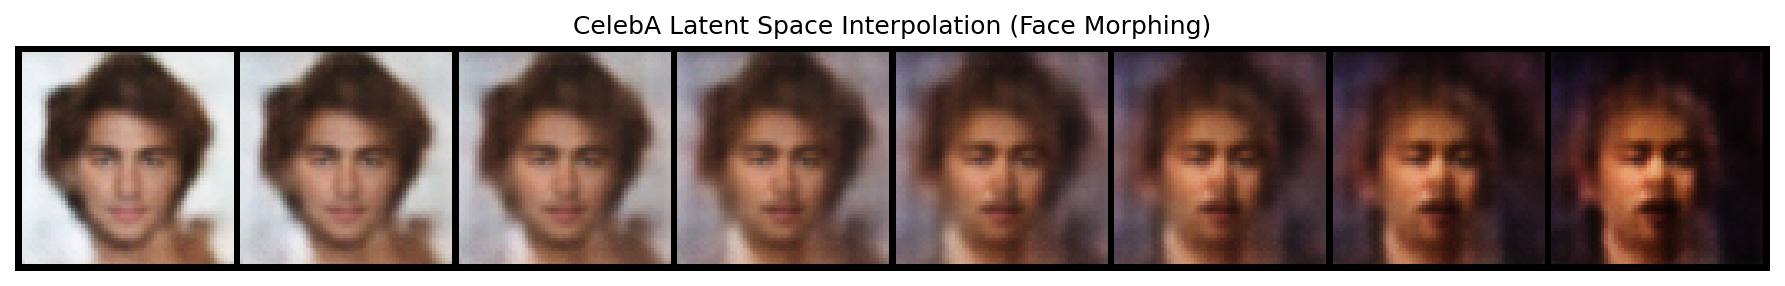

In [ ]:
from IPython.display import Image, display
import glob

# Display generated images
result_files = glob.glob('./results/celeba_results_epoch_*.png')
for file in sorted(result_files):
    display(Image(filename=file))
    print(f"Displaying: {file}")

# Display training curves
display(Image(filename='./results/celeba_training_curves.png'))

# Display latent interpolation
display(Image(filename='./results/celeba_latent_interpolation.png'))